In [ ]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

from utils.plot_utils import * # import plotting stuff
from utils.data_utils import load_movement_df # import data loading stuff

path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [2]:
from tqdm import tqdm
import datetime

path_to_save_samples_synthetic_test = os.path.join(results_dir, "real_testing", "community", "scenarios_paper_rho_negatives_SEQ", "rho_6%" )

gamma_prior = [0.01, 0.7]
beta_prior  = [0.001, 0.05]

param_prior_dict = {}
param_prior_dict["gamma"] = gamma_prior
param_prior_dict["beta"]  = beta_prior

if2_settings = {}
if2_settings["num_params"]       = len(param_prior_dict)
if2_settings["num_state_vars"]   = 4    # NOT USED IN THE ABM AS THE STATE SPACE (variables) are NOT CHANGED.
if2_settings["num_observations"] = 1
if2_settings["lambda_inf"]       = 1.01
if2_settings["num_iters_mif"]    = 20
if2_settings["alpha_mif"]        = 0.8  # Variance shrinking factor
if2_settings["type_cooling"]     = "geometric"
if2_settings["num_ensembles"]    = 300


posterior_df = []
truth_df     = []

RUN_IDS  = [1, 2, 3]

for idx_oev, run_id in enumerate(RUN_IDS):
    for idx_row, row in scenarios_df.iterrows():

        scenario_params_name = row.name_scenario

        path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, scenario_params_name)

        samples          = np.load( os.path.join(path_to_save_pid, f'weekly_samples_{run_id}.npz') )
        para_post_all    = samples["param_posterior"]
        param_mean_iter  = samples["theta"]
        param_mean_iter  = param_mean_iter[[0,1],:]
        para_post_iter   = para_post_all.mean(-2) # average over time

        params_label     = [r"$\gamma$", r"$\beta$"]
        truth_list       =  [row['γ'], row['β']]
        param_range      = list(param_prior_dict.values())
        gamma_mle        = para_post_iter[0,:,-1]
        beta_mle         = para_post_iter[1,:,-1]

        p_df                = pd.DataFrame(columns=["gamma", "beta", "scenario"])
        p_df["gamma"]       = gamma_mle
        p_df["beta"]        = beta_mle

        p_df["gamma_truth"] = truth_list[0]
        p_df["beta_truth"]  = truth_list[1]

        p_df["scenario"] = "Scenario " + str(idx_row+1)
        p_df["run_id"]   = run_id

        posterior_df.append(p_df)

posterior_df             = pd.concat(posterior_df, ignore_index=True)
posterior_df["type"]     = "MLE"
posterior_df["type_plt"] = posterior_df.apply(lambda x: x.type + " " + str(x.run_id), axis=1)


NameError: name 'sns' is not defined

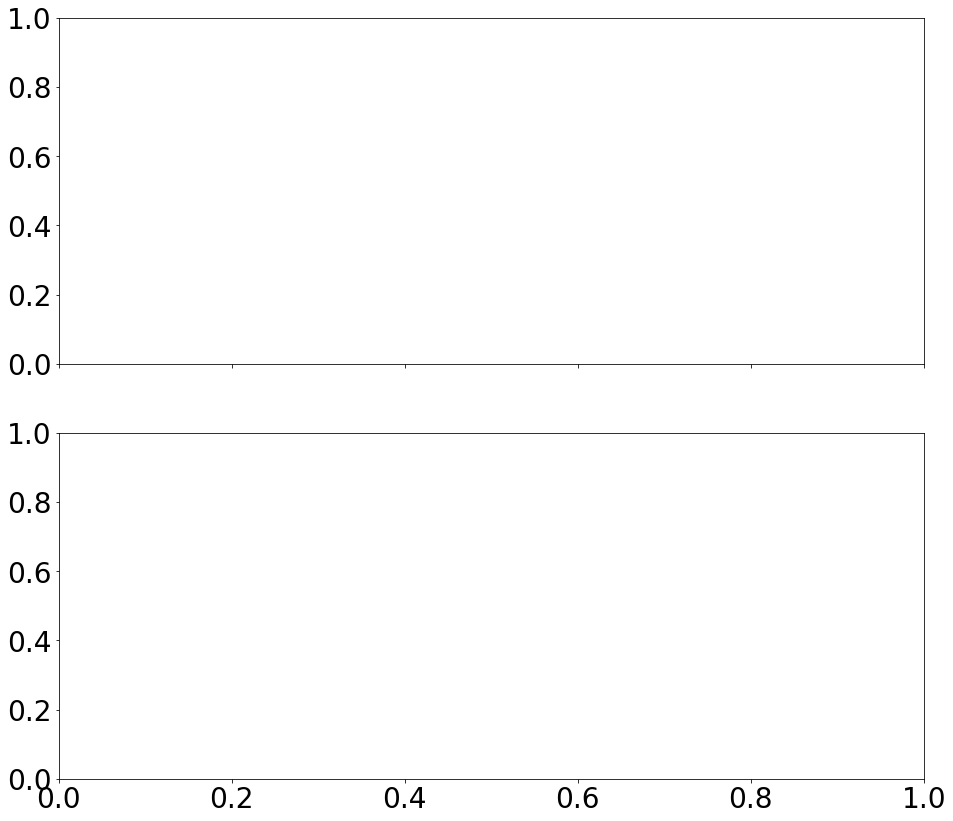

In [3]:
mean_mle_df                = posterior_df.groupby(["scenario", "run_id"]).mean().reset_index()
mean_mle_df["gamma_error"] = mean_mle_df["gamma"] - mean_mle_df["gamma_truth"]
mean_mle_df["beta_error"]  = mean_mle_df["beta"]  - mean_mle_df["beta_truth"]
mean_mle_df["scenario_id"] = mean_mle_df["scenario"].map(lambda x: int(x.split(" ")[-1]))
mean_mle_df                = mean_mle_df.sort_values(by="scenario_id")

mean_mle_df["gamma_relative_error"] = mean_mle_df["gamma_error"] / mean_mle_df["gamma_truth"] * 100
mean_mle_df["beta_relative_error"] = mean_mle_df["beta_error"]  / mean_mle_df["beta_truth"]   * 100

mean_mle_df["gamma_relative_prior_error"] = mean_mle_df["gamma_error"] / (gamma_prior[1] - gamma_prior[0]) * 100
mean_mle_df["beta_relative_prior_error"]  = mean_mle_df["beta_error"]  / (beta_prior[1] - beta_prior[0])   * 100

fig, ax = plt.subplots(2, 1, figsize=(15.5, 14), sharey=True, sharex=True)

sns.barplot(ax=ax[0], data=mean_mle_df,  x="gamma_error", y="scenario", hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[0].axvline(0, color="k", clip_on=False)

sns.barplot(ax=ax[1], data=mean_mle_df,  x="beta_error", y="scenario", hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[1].axvline(0, color="k", clip_on=False)

ax[0].set_xlabel(r"Error $= \gamma_{{MLE}}-\gamma$")
ax[1].set_xlabel(r"Error $= \beta_{{MLE}}-\beta$")

ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

sns.despine(right=True, top=True)

ax[0].legend().remove()
ax[1].legend().remove()

plt.tight_layout()

path_to_save  = os.path.join(path_to_ms_figs, "ErrorMLE.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


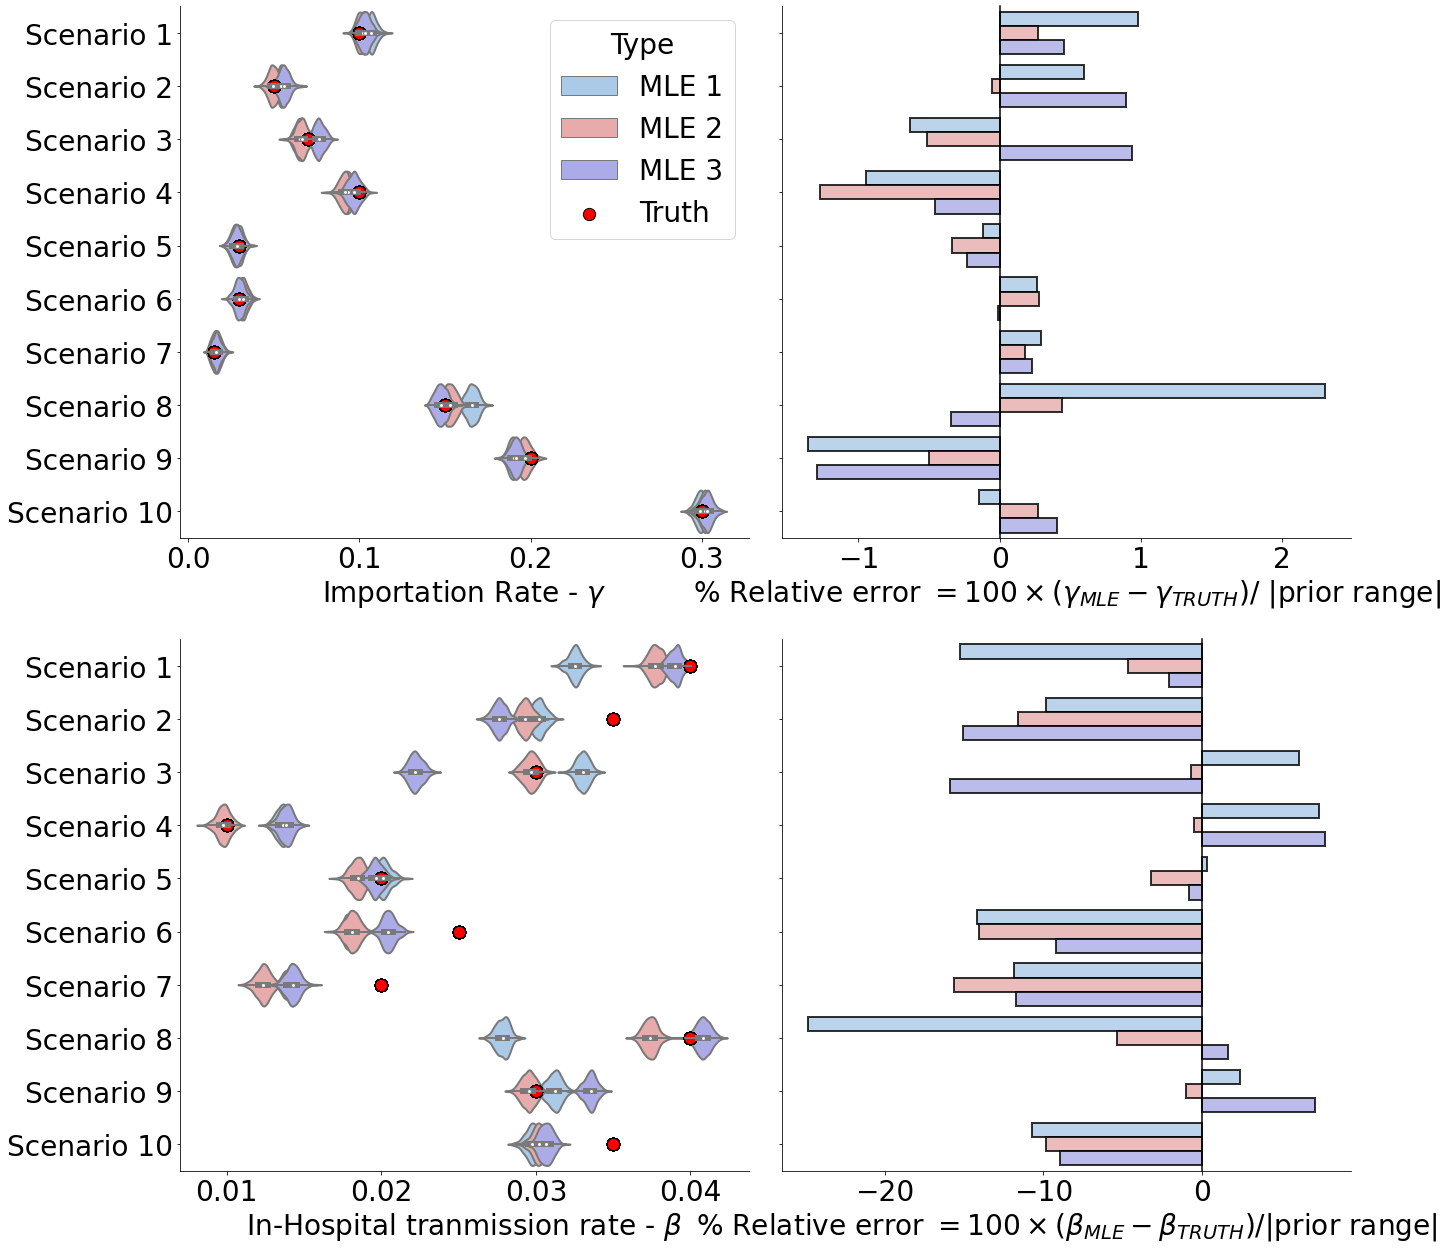

In [15]:
#fig, ax = plt.subplots(2, 1, figsize=(16.5,  12.2), sharey=True)
fig, ax = plt.subplots(2, 2, figsize=(19.5, 18), sharey=True, sharex=False)

run_id = 1
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)

run_id = 2
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

run_id = 3
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)




sns.scatterplot(ax=ax[0,0], data=posterior_df, x="gamma_truth", y="scenario", s=150, facecolor="red", edgecolor="k", marker="o", label="Truth", lw=20)
sns.scatterplot(ax=ax[1,0], data=posterior_df, x="beta_truth", y="scenario",  s=150, facecolor="red", edgecolor="k", marker="o", label="Truth",  lw=20)

#sns.scatterplot(ax=ax[0], data=posterior_df.groupby("scenario").mean(), x="gamma", y="scenario", s=150, facecolor="green", edgecolor="k", marker="^", label="MLE", lw=20)
#sns.scatterplot(ax=ax[1], data=posterior_df.groupby("scenario").mean(), x="beta", y="scenario", s=150, facecolor="green", edgecolor="k", marker="^", label="MLE", lw=20)

sns.despine(right=True, top=True)

ax[0,0].legend(title="Type", loc="upper right")
ax[1,0].legend().remove()
ax[0,0].set_xlabel(r"Importation Rate - $\gamma$")
ax[1,0].set_xlabel(r"In-Hospital tranmission rate - $\beta$")
ax[0,0].set_ylabel(None)
ax[1,0].set_ylabel(None)


###############-----###############----###############----###############

sns.barplot(ax=ax[0,1], data=mean_mle_df,  x="gamma_relative_prior_error", y="scenario",  hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[0,1].axvline(0, color="k", clip_on=False)

sns.barplot(ax=ax[1,1], data=mean_mle_df,  x="beta_relative_prior_error", y="scenario",  hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[1,1].axvline(0, color="k", clip_on=False)

ax[0,1].set_xlabel(r"% Relative error $=100\times (\gamma_{{MLE}}-\gamma_{{TRUTH}}) /$ |prior range|")
ax[1,1].set_xlabel(r"% Relative error $=100\times (\beta_{{MLE}}-\beta_{{TRUTH}}) /$|prior range|")

ax[0,1].set_ylabel(None)
ax[1,1].set_ylabel(None)

ax[0,1].legend().remove()
ax[1,1].legend().remove()

#ax[0].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)
#ax[1].grid(linestyle='-', linewidth=1, axis="x", alpha=0.3)
plt.tight_layout()
path_to_save  = os.path.join(path_to_ms_figs, "MLE_RelPriorRangeError_3Runs.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)


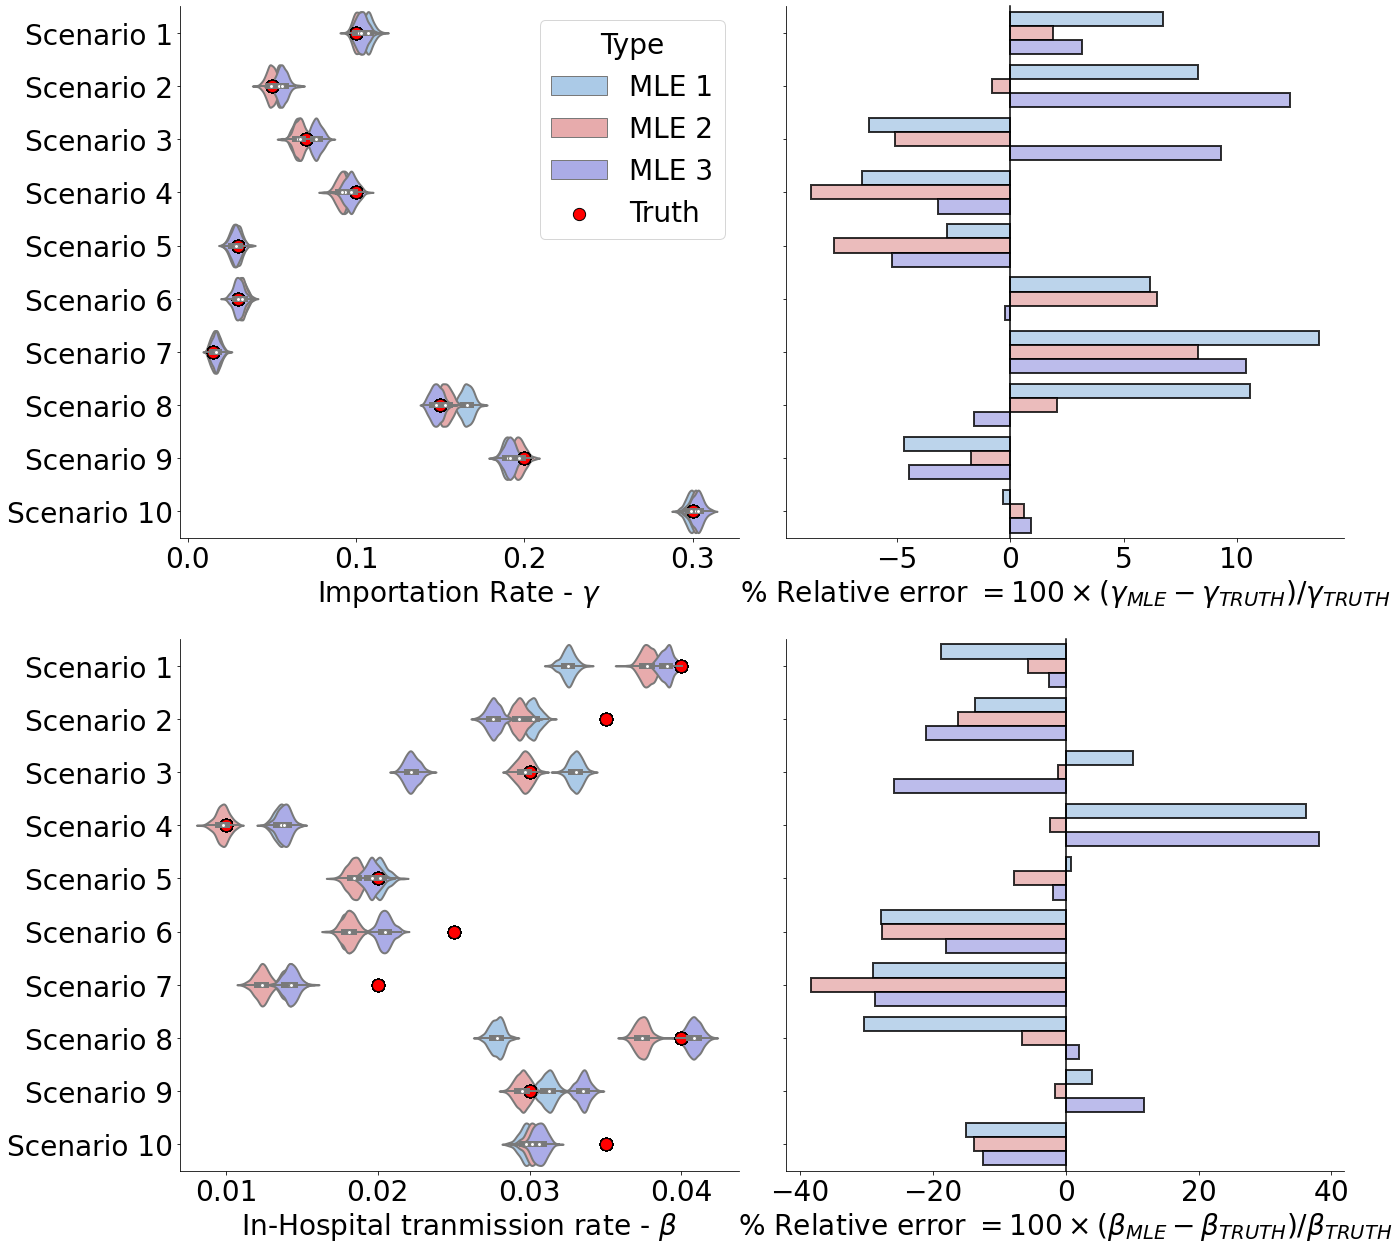

In [8]:
#fig, ax = plt.subplots(2, 1, figsize=(16.5,  12.2), sharey=True)
fig, ax = plt.subplots(2, 2, figsize=(19.5, 18), sharey=True, sharex=False)

run_id = 1
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)

run_id = 2
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

run_id = 3
sns.violinplot(ax=ax[0,0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=ax[1,0], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

sns.scatterplot(ax=ax[0,0], data=posterior_df, x="gamma_truth", y="scenario", s=150, facecolor="red", edgecolor="k", marker="o", label="Truth", lw=20)
sns.scatterplot(ax=ax[1,0], data=posterior_df, x="beta_truth", y="scenario",  s=150, facecolor="red", edgecolor="k", marker="o", label="Truth",  lw=20)


sns.despine(right=True, top=True)

ax[0,0].legend(title="Type", loc="upper right")
ax[1,0].legend().remove()
ax[0,0].set_xlabel(r"Importation Rate - $\gamma$")
ax[1,0].set_xlabel(r"In-Hospital tranmission rate - $\beta$")
ax[0,0].set_ylabel(None)
ax[1,0].set_ylabel(None)


###############-----###############----###############----###############

sns.barplot(ax=ax[0,1], data=mean_mle_df,  x="gamma_relative_error", y="scenario",  hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[0,1].axvline(0, color="k", clip_on=False)

sns.barplot(ax=ax[1,1], data=mean_mle_df,  x="beta_relative_error", y="scenario",  hue="run_id", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], edgecolor="k", alpha=0.8, lw=2)
ax[1,1].axvline(0, color="k", clip_on=False)

ax[0,1].set_xlabel(r"% Relative error $=100\times (\gamma_{{MLE}}-\gamma_{{TRUTH}}) / \gamma_{{TRUTH}}$")
ax[1,1].set_xlabel(r"% Relative error $=100\times (\beta_{{MLE}}-\beta_{{TRUTH}}) / \beta_{{TRUTH}}$")

ax[0,1].set_ylabel(None)
ax[1,1].set_ylabel(None)

ax[0 ,1].legend().remove()
ax[1, 1].legend().remove()

plt.tight_layout()

path_to_save  = os.path.join(path_to_ms_figs, "MLE_RelTruthError_3Runs.png")
fig.savefig(path_to_save, dpi=300, transparent=True)



In [9]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm( (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd )

def sample_params_normal(dict_params_range, params_mean, params_var, num_ensembles=300):
    param_ens_prior = []
    for idx_p, p in enumerate(dict_params_range.keys()):
        norm_gen = get_truncated_normal(mean=params_mean[idx_p], sd=params_var[idx_p]**(1/2), low=dict_params_range[p][0], upp=dict_params_range[p][1])

        param_ens_prior.append( norm_gen.rvs(num_ensembles) )

    return np.array( param_ens_prior )

def amr_model_step_test_communities(patients_state, gamma, beta, alpha_ens, movement_date, wardid2size, ward_observation_dict=None, se=6/100):
    """[summary]

    Args:
        patients_state ([type]): Numpy array with patient state per ensemble. shape: num_patients x num_ensembles.
        wards_state    ([type]): Numpy array with patient state per ensemble. shape: num_wards x num_ensembles.
        param_ens      ([type]): Dictionary with parameters to iterate de model.
        movement_date  ([type]): DataFrame with movement information.

    Returns:
        patients_state      ([type]): Numpy array with patient state per ensemble after model step. shape: num_patients x num_ensembles.
        wards_state         ([type]): Numpy array with patient state per ensemble after model step. shape: num_wards x num_ensembles.
        colonized           ([type]): Total colonized patient after model step.
        colonized_imported  ([type]): Total colonized patient by importation after model step.
        positive            ([type]): Total colonized detected patients (positive) after model step.
    """

    num_wards    = len(wardid2size.values() )
    active_w_df  = movement_date[["ward_id"]]                                # Active wards
    active_p_df  = movement_date[["mrn_id", "ward_id", "first_day", "test"]] # Active patients

    num_patients  = patients_state.shape[0]
    num_ensembles = patients_state.shape[1]


    active_patients  = active_p_df.mrn_id.values
    active_wards     = np.unique(active_w_df.values)
    new_patients     = active_p_df[active_p_df.first_day==True]["mrn_id"].values

    gamma_ens = gamma
    beta_ens  = beta

    if new_patients.shape[0]>0:
        patients_state[new_patients, :]   = np.ones(shape=(new_patients.shape[0], 1)) * gamma_ens

        # Potential colonized patients by importation
        prob_patients                    = np.where(patients_state!=0)
        patients_state[prob_patients]    = np.random.random(size=(prob_patients[0].shape)) <= patients_state[prob_patients]

    imported_patients      = patients_state[new_patients, :]
    #print("imported patients {} mean".format(np.mean(np.sum(imported_patients,axis=0))))

    ward_colonized        = np.zeros((num_wards, num_ensembles) )
    ward_nosocomial       = np.zeros((num_wards, num_ensembles) )
    ward_imported         = np.zeros((num_wards, num_ensembles) )
    ward_positive         = np.zeros((num_wards, num_ensembles) )
    ward_negative         = np.zeros((num_wards, num_ensembles) )

    num_ward_chunks       = len(set(list(ward_observation_dict.values())))
    ward_chunk_colonized  = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_nosocomial = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_imported   = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_positive   = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_negative   = np.zeros((num_ward_chunks, num_ensembles) )

    # compute total imported patients to respective wards
    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_new_ward  = active_p_df[active_p_df.ward_id==ward_id]#["mrn_id"].values
        active_patients_new_ward  = active_patients_new_ward[active_patients_new_ward.first_day==True]["mrn_id"].values

        ward_chunk_imported[ward_observation_dict[ward_id], :] += np.sum(patients_state[active_patients_new_ward, :], axis=0)
        ward_imported[ward_id, :]                              += np.sum(patients_state[active_patients_new_ward, :], axis=0)

    patients_state    = patients_state.copy()
    imported_patients = patients_state.copy()

    p_status           = patients_state * (1 - np.ones(shape=(num_patients,1)) * alpha_ens)


    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_ward              = active_p_df[active_p_df.ward_id==ward_id]["mrn_id"].values
        colonized_patients                = np.sum(patients_state[active_patients_ward,:], axis=0)

        foi_ward                          = beta_ens  * colonized_patients / wardid2size[ward_id] # Ward force of infection.
        foi                               = foi_ward
        p_status[active_patients_ward, :] = p_status[active_patients_ward, :] + foi

    prob_patients   = np.where(p_status!=0)
    #tested_patients = active_p_df[active_p_df.test==True]["mrn_id"].values

    p_status[prob_patients[0], prob_patients[1]] = np.random.random(size=(prob_patients[0].shape)) <= p_status[prob_patients[0], prob_patients[1]]
    patients_state                               = p_status.copy()

    patients_state_tested = se * patients_state
    patients_state_tested     = np.random.random(size=(num_patients, num_ensembles)) <=  patients_state_tested
    patients_state_not_tested = patients_state-patients_state_tested

    # compute total imported patients to respective wards
    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_new_ward      = active_p_df[active_p_df.ward_id==ward_id]["mrn_id"].values

        chunk_id = ward_observation_dict[ward_id]

        ward_chunk_colonized[chunk_id, :]  += np.sum(patients_state[active_patients_new_ward, :], axis=0)
        ward_colonized[ward_id, :]                               += np.sum(patients_state[active_patients_new_ward, :], axis=0)

        ward_chunk_nosocomial[chunk_id, :] += np.sum(patients_state[active_patients_new_ward, :]-imported_patients[active_patients_new_ward, :], axis=0)
        ward_nosocomial[ward_id, :]                              += np.sum(patients_state[active_patients_new_ward, :]-imported_patients[active_patients_new_ward, :], axis=0)

        active_patients_new_ward           = active_p_df[active_p_df.ward_id==ward_id]
        active_patients_detected_ward      = active_patients_new_ward[active_patients_new_ward.test==True]["mrn_id"].values

        ward_chunk_positive[chunk_id, :]   += np.sum(patients_state_tested[active_patients_detected_ward, :], axis=0)
        ward_positive[ward_id, :]          += np.sum(patients_state_tested[active_patients_detected_ward, :], axis=0)

        ward_chunk_negative[chunk_id, :]   += np.sum(patients_state_not_tested[active_patients_detected_ward, :], axis=0)
        ward_negative[ward_id, :]          += np.sum(patients_state_not_tested[active_patients_detected_ward, :], axis=0)

    return patients_state,  ward_colonized, ward_imported, ward_nosocomial, ward_positive, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive, ward_negative, ward_chunk_negative
   #return patients_state, colonized, colonized_imported, colonized_nosocomial, positive, ward_colonized, ward_nosocomial, ward_imported, ward_positive, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive

def amr_model_step_test_communities_inference(patients_state, gamma, beta, alpha_ens, movement_date, wardid2size, ward_observation_dict=None, se=6/100):
    """[summary]

    Args:
        patients_state ([type]): Numpy array with patient state per ensemble. shape: num_patients x num_ensembles.
        wards_state    ([type]): Numpy array with patient state per ensemble. shape: num_wards x num_ensembles.
        param_ens      ([type]): Dictionary with parameters to iterate de model.
        movement_date  ([type]): DataFrame with movement information.

    Returns:
        patients_state      ([type]): Numpy array with patient state per ensemble after model step. shape: num_patients x num_ensembles.
        wards_state         ([type]): Numpy array with patient state per ensemble after model step. shape: num_wards x num_ensembles.
        colonized           ([type]): Total colonized patient after model step.
        colonized_imported  ([type]): Total colonized patient by importation after model step.
        positive            ([type]): Total colonized detected patients (positive) after model step.
    """

    num_wards    = len(wardid2size.values() )
    active_w_df  = movement_date[["ward_id"]]                                # Active wards
    active_p_df  = movement_date[["mrn_id", "ward_id", "first_day", "test"]] # Active patients

    num_patients  = patients_state.shape[0]
    num_ensembles = patients_state.shape[1]

    active_patients  = active_p_df.mrn_id.values
    active_wards     = np.unique(active_w_df.values)
    new_patients     = active_p_df[active_p_df.first_day==True]["mrn_id"].values

    gamma_ens = gamma
    beta_ens  = beta

    if new_patients.shape[0]>0:
        patients_state[new_patients, :]   = np.ones(shape=(new_patients.shape[0], 1)) * gamma_ens

        # Potential colonized patients by importation
        prob_patients                    = np.where(patients_state!=0)
        patients_state[prob_patients]    = np.random.random(size=(prob_patients[0].shape)) <= patients_state[prob_patients]


    num_ward_chunks       = len(set(list(ward_observation_dict.values())))


    ward_colonized        = np.zeros((num_wards, num_ensembles) )
    ward_nosocomial       = np.zeros((num_wards, num_ensembles) )
    ward_positive         = np.zeros((num_wards, num_ensembles) )
    ward_negative         = np.zeros((num_wards, num_ensembles) )
    ward_imported         = np.zeros((num_wards, num_ensembles) )

    ward_chunk_colonized  = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_nosocomial = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_positive   = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_negative   = np.zeros((num_ward_chunks, num_ensembles) )
    ward_chunk_imported   = np.zeros((num_ward_chunks, num_ensembles) )

    # compute total imported patients to respective wards
    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_new_ward            = active_p_df[active_p_df.ward_id==ward_id]#["mrn_id"].values
        active_patients_new_ward            = active_patients_new_ward[active_patients_new_ward.first_day==True]["mrn_id"].values

        chunk_id = ward_observation_dict[ward_id]

        ward_chunk_imported[chunk_id, :]   += np.sum(patients_state[active_patients_new_ward, :], axis=0)
        ward_imported[ward_id, :]          += np.sum(patients_state[active_patients_new_ward, :], axis=0)

    patients_state    = patients_state.copy()

    p_status           = patients_state * (1 - np.ones(shape=(num_patients,1)) * alpha_ens)

    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_ward              = active_p_df[active_p_df.ward_id==ward_id]["mrn_id"].values
        colonized_patients                = np.sum(patients_state[active_patients_ward,:], axis=0)

        chunk_id = ward_observation_dict[ward_id]

        ward_chunk_colonized[chunk_id, :]   += np.sum(patients_state[active_patients_ward, :], axis=0)
        ward_colonized[ward_id, :]          += np.sum(patients_state[active_patients_ward, :], axis=0)

        foi_ward                          = beta_ens  * colonized_patients / wardid2size[ward_id] # Ward force of infection.
        foi                               = foi_ward
        p_status[active_patients_ward, :] = p_status[active_patients_ward, :] + foi

    prob_patients   = np.where(p_status!=0)

    p_status[prob_patients[0], prob_patients[1]] = np.random.random(size=(prob_patients[0].shape)) <= p_status[prob_patients[0], prob_patients[1]]
    patients_state                               = p_status.copy()


    patients_state_tested = se * patients_state

    patients_state_tested     = np.random.random(size=(num_patients, num_ensembles)) <=  patients_state_tested
    patients_state_not_tested = patients_state-patients_state_tested

    # compute total imported patients to respective wards
    for idx_ward, ward_id in enumerate(active_wards):
        active_patients_new_ward      = active_p_df[active_p_df.ward_id==ward_id]["mrn_id"].values

        chunk_id = ward_observation_dict[ward_id]


        active_patients_new_ward           = active_p_df[active_p_df.ward_id==ward_id]
        active_patients_detected_ward      = active_patients_new_ward[active_patients_new_ward.test==True]["mrn_id"].values

        ward_chunk_positive[chunk_id, :]   += np.sum(patients_state_tested[active_patients_detected_ward, :], axis=0)
        ward_positive[ward_id, :]          += np.sum(patients_state_tested[active_patients_detected_ward, :], axis=0)

        ward_chunk_negative[chunk_id, :]   += np.sum(patients_state_not_tested[active_patients_detected_ward, :], axis=0)
        ward_negative[ward_id, :]          += np.sum(patients_state_not_tested[active_patients_detected_ward, :], axis=0)

    ward_nosocomial       = ward_colonized - ward_imported
    ward_chunk_nosocomial = ward_chunk_colonized - ward_chunk_imported

    return patients_state, ward_colonized, ward_nosocomial, ward_imported, ward_positive, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive, ward_negative, ward_chunk_negative


def simulate_model(model, movement_data, ward_id2size, ward2community, params, abm_settings):
    # Simulate Model
    alpha_ens    = np.random.uniform( 1/365, 1/175, size=(abm_settings["num_patients"], abm_settings["num_ensembles"]))

    gamma_truth  = params[0, :].mean()
    beta_truth   = params[1, :].mean()

    gamma_ens = np.ones((1, abm_settings["num_ensembles"])) * gamma_truth
    beta_ens  = np.ones((1, abm_settings["num_ensembles"])) * beta_truth


    patients_state     = np.zeros((abm_settings["num_patients"], abm_settings["num_ensembles"]))

    ward_negative           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))
    ward_positive           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))
    ward_colonized          = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))
    ward_nosocomial         = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))
    ward_imported           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))


    ward_chunk_negative           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))
    ward_chunk_positive           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))
    ward_chunk_colonized          = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))
    ward_chunk_nosocomial         = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))
    ward_chunk_imported = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))

    ward_negative           = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards"], abm_settings["num_ensembles"]))
    ward_chunk_negative     = np.zeros((len(abm_settings["dates"] ),  abm_settings["num_wards_chunks"], abm_settings["num_ensembles"]))

    # movement_df = movement_df.reset_index().drop_duplicates(subset=["date", "ward_id"], keep="first").set_index("date")
    # Simulate

    for i_d, date in tqdm(enumerate(list(abm_settings["dates"] ))):
        movement_date = movement_data.loc[date]
        patients_state,  ward_colonized[i_d,:], ward_imported[i_d,:], ward_nosocomial[i_d,:], ward_positive[i_d,:], ward_chunk_colonized[i_d,:], ward_chunk_nosocomial[i_d,:], ward_chunk_imported[i_d,:], ward_chunk_positive[i_d,:], ward_negative[i_d,:], ward_chunk_negative[i_d,:]  = model(patients_state, gamma_ens, beta_ens, alpha_ens, movement_date, ward_id2size, ward2community)

    colonized          = ward_colonized.sum(1)
    colonized_imported = ward_chunk_imported.sum(1)
    nosocomial         = ward_nosocomial.sum(1)
    positive           = ward_positive.sum(1)
    negative           = ward_negative.sum(1)

    return colonized, colonized_imported, nosocomial, positive, negative, ward_colonized, ward_nosocomial, ward_imported, ward_positive, ward_negative, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive, ward_chunk_negative

def compute_calibration_ward_chunks(ward_chunk_pos, obs_chunk_pos, resample="W-Sun"):

    dates                  = pd.date_range(start=pd.to_datetime("2020-02-01"), periods=ward_chunk_pos.shape[0])
    dates_study            = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq=resample)

    num_ensembles          = ward_chunk_pos.shape[-1]
    num_chunks             = ward_chunk_pos.shape[-2]

    df_ward_sims           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    df_ward_sims["date"]   = flatten_list([ [date]*num_ensembles for date in  list(dates)])
    df_ward_sims["id_ens"] = list(range(num_ensembles)) * len(dates)

    for ward_idx in range(num_chunks):
        ward_pos                        = ward_chunk_pos[:,ward_idx,:]
        df_ward_sims[f"pos_{ward_idx}"] = ward_pos.flatten()

    df_ward_sims = df_ward_sims.set_index(["date", "id_ens"]).unstack([1]).resample(resample).sum().stack().reset_index()#.set_index("date").reset_index()
    df_ward_sims = df_ward_sims[df_ward_sims.date.isin(dates_study)]

    obs_df           = pd.DataFrame(columns=["date"]+[f"pos_{idx_ens}" for idx_ens in range(num_chunks)])
    obs_df["date"]   = dates
    for ward_idx in range(num_chunks):
        ward_pos                  = obs_chunk_pos[:,ward_idx]
        obs_df[f"pos_{ward_idx}"] = ward_pos.flatten()

    obs_df       = obs_df[obs_df.date.isin(dates)].set_index("date")
    obs_df       = obs_df.resample(resample).sum().reset_index()


    confidence_use = [25/100, 55/100, 75/100, 90/100]

    calibration_df = []
    for cluster_id in range(num_chunks):

        cal_df               = pd.DataFrame(columns=["confidence", "proportion_inside"])
        cal_df["confidence"] = confidence_use
        cal_df               = cal_df.set_index("confidence")


        for confidence in cal_df.index.values:
            chunk_cluster                  = ward_chunk_pos[:,cluster_id,:]
            df_ward                        = pd.DataFrame(chunk_cluster)
            df_ward["date"]                = dates
            df_ward                        = df_ward.set_index("date").resample(resample).sum().reset_index()
            df_ward                        = df_ward[df_ward.date.isin(dates_study)].set_index("date")
            df_resume                      = df_ward.T.quantile(q=[1-confidence, confidence]).T
            df_resume["obs"]               = obs_df[f"pos_{cluster_id}"].values
            df_resume["calibration"]       = df_resume.apply(lambda x: x[1-confidence] <= np.double(x.obs) <= x[confidence], axis=1)

            cal_df.loc[confidence]         = df_resume["calibration"].sum()/len(df_resume)

        cal_df["cluster_id"] = cluster_id
        calibration_df.append(cal_df)

    calibration_df  = pd.concat(calibration_df)

    return calibration_df

In [10]:
date_min         = pd.to_datetime("2020-02-01")
date_max         = pd.to_datetime("2021-02-28")
dates_simulation = pd.date_range(start=date_min, end=date_max)

movement_df  = pd.read_csv('../abm_inference_data/data/patients_info_test_corrected.csv', parse_dates=["date"])#.drop(columns=["Unnamed: 0"])
movement_df  = movement_df.dropna(subset=["date"])
movement_df            = movement_df.set_index("date")
movement_df            = movement_df.loc[dates_simulation]

id2ward = pd.read_csv(  os.path.join(feb_hosp_records_path, "ward2id.csv"))
id2ward = {row.ward_id: row.ward for idx, row in id2ward.iterrows()}

id2room = pd.read_csv(  os.path.join(feb_hosp_records_path, "room2id.csv"))
id2room = {row.room_id: row.room for idx, row in id2room.iterrows()}

id2mrn = pd.read_csv(  os.path.join(feb_hosp_records_path, "mrn2id.csv"))
id2mrn = {row.mrn_id: row.mrn for idx, row in id2mrn.iterrows()}

movement_df["mrn"]  = movement_df["mrn_id"].map(id2mrn)
movement_df["ward"] = movement_df["ward_id"].map(id2ward)
movement_df["room"] = movement_df["room_id"].map(id2room)

movement_df = movement_df.drop(columns=["ward_id", "room_id", "mrn_id"])

ward2id     = {ward: idx for idx, ward in enumerate( movement_df.ward.unique())}
room2id     = {room: idx for idx, room in enumerate( movement_df.room.unique())}
mrn2id      = {mrn: idx for idx, mrn in enumerate( movement_df.mrn.unique())}

movement_df["ward_id"] = movement_df["ward"].map(ward2id)
movement_df["room_id"] = movement_df["room"].map(room2id)
movement_df["mrn_id"]  = movement_df["mrn"].map(mrn2id)
movement_df["test"]    = movement_df["test"].map(lambda x: int(x))

movement_df    = movement_df[["first_day", "ward_id", "mrn_id", "test", "specimen", "specimen_group", "organism_name", "organism_id"]]

communities_df = pd.read_csv(os.path.join("..", "abm_inference_data", "data", "communities_infomap.csv"))

ward2community              = communities_df[["ward_id", "community"]].copy()
ward2community["community"][ward2community["community"]>=6] = 6

ward2community["community"] = ward2community["community"]-1
ward2community = {r.ward_id: r.community for idx, r in ward2community.iterrows()}


movement_df["cluster_id"] = movement_df["ward_id"].map(ward2community)
movement_df               = movement_df[["first_day", "cluster_id", "ward_id", "mrn_id", "test", "specimen", "specimen_group", "organism_name", "organism_id"]]

tests_df = movement_df[movement_df.test==1]


/Users/chaosdonkey06/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
from SCENARIOS import return_scenarios_paper
scenarios_dicts = return_scenarios_paper()

abm_settings                     = {}
abm_settings["num_communities"]  = movement_df.ward_id.unique().shape[0]
abm_settings["num_patients"]     = movement_df.mrn_id.unique().shape[0]
abm_settings["num_wards"]        = movement_df.ward_id.unique().shape[0]
abm_settings["num_wards_chunks"] = len(set(list(ward2community.values())))
abm_settings["dates"]            = np.unique(movement_df.index.values)
abm_settings["num_ensembles"]    = 300


In [12]:
ward_size_df = movement_df.reset_index(); ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df = ward_size_df.groupby("ward_id").mean().reset_index()
ward_id2size = {r.ward_id: r.num_patients for idx, r in ward_size_df.iterrows()}

run_id =  1

for idx_scenario in range(len(scenarios_dicts)):

    scenario             = scenarios_dicts[idx_scenario]
    scenario_params      = scenario["params_truth"][0]
    scenario_params_name = scenario["name"]
    params_dict          = scenario_params
    #path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, "fixed_scenarios_cooling_{}_alpha_mif_{}_2_fixedD_10_triangular".format(if2_settings["type_cooling"], if2_settings["alpha_mif"]), scenario_params_name)

    print("Simulating for scenario: {}".format(scenario_params_name))
    path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, scenario_params_name)

    if run_id==-1:
        samples         = np.load( os.path.join(path_to_save_pid, f'weekly_samples.npz') )
    else:
        samples         = np.load( os.path.join(path_to_save_pid, f'weekly_samples_{run_id}.npz') )

    para_post_all   = samples["param_posterior"]
    param_mean_iter = samples["theta"]
    param_mean_iter = param_mean_iter[[0,1],:]
    para_post_iter  = para_post_all.mean(-2) # average over time

    params_label = [r"$\gamma$", r"$\beta$"]
    truth_list   = [scenario_params["gamma"], scenario_params["beta"]]
    param_range  = list(param_prior_dict.values())

    gamma_mle       = para_post_iter[0,:,-1]
    beta_mle        = para_post_iter[1,:,-1]
    inferred_params = para_post_iter[[0,1], :, -1]

    if os.path.isfile(os.path.join(path_to_save_pid, f'mle_simulation_{run_id}.npz')):
        continue

    colonized, colonized_imported, nosocomial, positive, negative, ward_colonized, ward_nosocomial, ward_imported, ward_positive, ward_negative, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive, ward_chunk_negative = simulate_model(amr_model_step_test_communities, movement_df, ward_id2size, ward2community, inferred_params, abm_settings)
    #colonized, colonized_imported, nosocomial, positive, negative, ward_colonized, ward_nosocomial, ward_imported, ward_positive, ward_negative, ward_chunk_colonized, ward_chunk_nosocomial, ward_chunk_imported, ward_chunk_positive, ward_chunk_negative
    if run_id==-1:
        path_to_save_sims = os.path.join(os.path.join(path_to_save_pid, f'mle_simulation.npz'))
    else:
        path_to_save_sims = os.path.join(os.path.join(path_to_save_pid, f'mle_simulation_{run_id}.npz'))

    np.savez_compressed(path_to_save_sims,
                                    ward_colonized                = ward_colonized,
                                    ward_nosocomial               = ward_nosocomial,
                                    ward_imported                 = ward_imported,
                                    ward_positive                 = ward_positive,
                                    ward_negative                 = ward_negative,
                                    ward_chunk_colonized          = ward_chunk_colonized,
                                    ward_chunk_nosocomial         = ward_chunk_nosocomial,
                                    ward_chunk_imported           = ward_chunk_imported,
                                    ward_chunk_positive           = ward_chunk_positive,
                                    ward_chunk_negative           = ward_chunk_negative)



Simulating for scenario: scenario1
Simulating for scenario: scenario2
Simulating for scenario: scenario3
Simulating for scenario: scenario4
Simulating for scenario: scenario5
Simulating for scenario: scenario6
Simulating for scenario: scenario7
Simulating for scenario: scenario8
Simulating for scenario: scenario9
Simulating for scenario: scenario10


In [43]:
from SCENARIOS import return_scenarios_paper
from itertools import chain

scenarios_dicts = return_scenarios_paper()

pos_all_df = []
obs_all_df = []

def create_variable_df(abm_settings, samples, variable_name):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = abm_settings["dates"]
    df["variable"] = [variable_name]*len(abm_settings["dates"])
    return df

mle_df = []
obs_df = []

calibration_df = []
for idx_scenario in tqdm(range(len(scenarios_dicts))):

    scenario             = scenarios_dicts[idx_scenario]
    scenario_params      = scenario["params_truth"][0]
    scenario_params_name = scenario["name"]
    params_dict          = scenario_params

    path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, scenario_params_name)

    sim_samples = np.load(os.path.join(path_to_save_pid, f'mle_simulation_{run_id}.npz'))

    # # Samples from MLE
    colonized_imported_mle  = np.maximum(sim_samples["ward_chunk_imported"].sum(-2),  0);    colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    colonized_mle           = np.maximum(sim_samples["ward_chunk_colonized"].sum(-2), 0);    colonized_mle_df          = create_df_response(colonized_mle.T         , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    positive_mle            = np.maximum(sim_samples["ward_chunk_positive"].sum(-2),  0);    positive_mle_df           = create_df_response(positive_mle.T          , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()

    nosocomial_mle          = sim_samples["ward_chunk_colonized"].sum(-2)-sim_samples["ward_chunk_imported"].sum(-2);              nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()


    ward_colonized_imp_mle  = sim_samples["ward_imported"];     ward_colonized_imp_mle_df = pd.concat([create_df_response(ward_colonized_imp_mle[:,idx,:].T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_nosocomial_mle     = sim_samples["ward_nosocomial"];   ward_nosocomial_mle_df    = pd.concat([create_df_response(ward_nosocomial_mle[:,idx,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_colonized_mle      = sim_samples["ward_colonized"];    ward_colonized_mle_df     = pd.concat([create_df_response(ward_colonized_mle[:,idx,:].T,     time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_positive_mle       = sim_samples["ward_positive"];     ward_positive_mle_df      = pd.concat([create_df_response(ward_positive_mle[:,idx,:].T,      time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])

    ward_chunk_colonized_imp_mle  = sim_samples["ward_chunk_imported"]; ward_chunk_colonized_imp_mle_df = pd.concat([create_df_response(ward_chunk_colonized_imp_mle[:,idx_chunk,:].T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_colonized_mle      = sim_samples["ward_chunk_colonized"];          ward_chunk_colonized_mle_df     = pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T,     time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_positive_mle       = sim_samples["ward_chunk_positive"];           ward_chunk_positive_mle_df      = pd.concat([create_df_response(ward_chunk_positive_mle[:,idx_chunk,:].T,      time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])

    ward_chunk_nosocomial_mle     = sim_samples["ward_chunk_nosocomial"];                  ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_nosocomial_mle     = ward_chunk_colonized_mle-ward_chunk_colonized_imp_mle;  ward_chunk_nosocomial_mle_df    = pd.concat([create_df_response(ward_chunk_nosocomial_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])

    # compute nosocomial from total colonizations and importations
    #ward_chunk_nosocomial_mle_df               =  pd.concat([create_df_response(ward_chunk_colonized_mle[:,idx_chunk,:].T-ward_chunk_colonized_imp_mle[:,idx_chunk,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx_chunk in range(abm_settings["num_wards_chunks"]) ])
    ward_chunk_colonized_imp_mle_df["cluster"] =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_nosocomial_mle_df["cluster"]    =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_colonized_mle_df["cluster"]     =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_positive_mle_df["cluster"]      =  list(chain(*[[idx_chunk+1]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))

    ward_chunk_colonized_imp_mle_df["variable"] = "ward_chunk_imported"
    ward_chunk_nosocomial_mle_df["variable"]    = "ward_chunk_nosocomial"
    ward_chunk_colonized_mle_df["variable"]     = "ward_chunk_colonized"
    ward_chunk_positive_mle_df["variable"]      = "ward_chunk_positive"
    colonized_imported_mle_df["variable"]       = "imported"
    nosocomial_mle_df["variable"]               = "nosocomial"
    colonized_mle_df["variable"]                = "colonized"
    positive_mle_df["variable"]                 = "positive"

    # concatenate mle results
    results_mle_df = pd.concat([colonized_mle_df, colonized_imported_mle_df, nosocomial_mle_df, positive_mle_df, ward_chunk_colonized_mle_df, ward_chunk_colonized_imp_mle_df, ward_chunk_positive_mle_df, ward_chunk_nosocomial_mle_df])
    results_mle_df["scenario"] = scenario_params_name

    ##### LOAD OBSERVATION USED FOR THE INFERENCE #####
    samples_infer                   = np.load(os.path.join(path_to_save_pid, f'simulation_infer_{run_id}.npz'))
    idx_infer                       = samples_infer['idx_use']
    colonized_imported_infer        = samples_infer["ward_colonized_imported"].sum(-2)[:len(abm_settings["dates"]),idx_infer];             colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = samples_infer["ward_positive"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                       nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = samples_infer["ward_colonized"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                      colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = samples_infer["ward_nosocomial"].sum(-2)[:len(abm_settings["dates"]),idx_infer];                     positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")

    ward_colonized_imp_infer       = samples_infer["ward_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer];      ward_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_colonized_imp_infer[:,idx], variable_name="ward_colonized_imported") for idx in range(abm_settings["num_wards"])])
    ward_colonized_infer           = samples_infer["ward_colonized"][:len(abm_settings["dates"]),:,idx_infer];               ward_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_colonized_infer[:,idx], variable_name="ward_colonized") for idx in range(abm_settings["num_wards"])])
    ward_positive_infer            = samples_infer["ward_positive"][:len(abm_settings["dates"]),:,idx_infer];                ward_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_positive_infer[:,idx], variable_name="ward_positive") for idx in range(abm_settings["num_wards"])])

    ward_nosocomial_infer          = samples_infer["ward_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];              ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])
    ward_nosocomial_infer          = ward_colonized_infer-ward_colonized_imp_infer;                                          ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])

    ward_colonized_imp_df["ward"] =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_nosocomial_df["ward"]    =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_colonized_df["ward"]     =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_positive_df["ward"]      =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))

    ward_chunk_colonized_imp_infer  = samples_infer["chunk_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer]; ward_chunk_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_imp_infer[:,idx_chunk], variable_name="ward_chunk_colonized_imported") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_colonized_infer      = samples_infer["chunk_colonized"][:len(abm_settings["dates"]),:,idx_infer];          ward_chunk_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_infer[:,idx_chunk], variable_name="ward_chunk_colonized") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_positive_infer       = samples_infer["chunk_positive"][:len(abm_settings["dates"]),:,idx_infer];           ward_chunk_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_chunk_positive_infer[:,idx_chunk], variable_name="ward_chunk_positive") for idx_chunk in range(abm_settings["num_wards_chunks"])])

    ward_chunk_nosocomial_infer     = samples_infer["chunk_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];         ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_nosocomial_infer     = ward_chunk_colonized_infer-ward_chunk_colonized_imp_infer;                          ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])


    colonized_imported_infer        = ward_chunk_colonized_imp_infer.sum(1);             colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = ward_chunk_nosocomial_infer.sum(1);                nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = ward_chunk_colonized_infer.sum(1);                 colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = ward_chunk_positive_infer.sum(1);                  positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")


    ward_chunk_colonized_imp_df["cluster"] =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_nosocomial_df["cluster"]    =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_colonized_df["cluster"]     =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_positive_df["cluster"]      =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))

    observations_infer_df             = pd.concat([colonized_df, colonized_imported_df, positive_df, nosocomial_df, ward_chunk_colonized_df, ward_chunk_colonized_imp_df, ward_chunk_positive_df, ward_chunk_nosocomial_df ]) #, ward_colonized_imp_df, ward_nosocomial_df, ward_colonized_df, ward_positive_df ])
    observations_infer_df["scenario"] = scenario_params_name
    observations_infer_df["date"]     = pd.to_datetime(observations_infer_df["date"])

    mle_df.append(results_mle_df)
    obs_df.append(observations_infer_df)

    # compute calibration stats
    cal_colonization_df = compute_calibration_ward_chunks(ward_chunk_colonized_mle, ward_chunk_colonized_infer, resample="W-Sun");         cal_colonization_df["variable"] = "colonized";  cal_colonization_df["scenario"] = scenario_params_name
    cal_importation_df  = compute_calibration_ward_chunks(ward_chunk_colonized_imp_mle, ward_chunk_colonized_imp_infer, resample="W-Sun"); cal_importation_df["variable"]  = "imported";   cal_importation_df["scenario"]  = scenario_params_name
    cal_nosocomial_df   = compute_calibration_ward_chunks(ward_chunk_nosocomial_mle, ward_chunk_nosocomial_infer, resample="W-Sun");       cal_nosocomial_df["variable"]   = "nosocomial"; cal_nosocomial_df["scenario"]   = scenario_params_name
    cal_positive_df     = compute_calibration_ward_chunks(ward_chunk_positive_mle, ward_chunk_positive_infer, resample="W-Sun");           cal_positive_df["variable"]     = "positive";   cal_positive_df["scenario"]     = scenario_params_name

    calibration_df.extend([cal_colonization_df, cal_importation_df, cal_nosocomial_df, cal_positive_df])

calibration_df = pd.concat(calibration_df).reset_index()
mle_df         = pd.concat(mle_df).reset_index(drop=True)
obs_df         = pd.concat(obs_df).reset_index(drop=True)

obs_w_df = obs_df.set_index(["date", "variable", "cluster", "scenario"]).unstack([1,2,3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
mle_w_df = mle_df.set_index(["date", "variable", "cluster", "scenario"]).unstack([1,2,3]).resample("W-Sun").sum().stack().stack().stack().reset_index()


100%|██████████| 10/10 [04:53<00:00, 29.36s/it]


In [44]:
var_ward_hosp_fit  = ["ward_colonized", "ward_colonized_imported", "ward_positive", "ward_nosocomial"]
scenarios          = ["scenario1", "scenario2", "scenario3", "scenario4", "scenario5", "scenario6", "scenario7", "scenario8", "scenario9", "scenario10"]
var_hosp_fit       = ["colonized", "colonized_imported", "positive", "nosocomial"]
dates_w_sun        = mle_w_df["date"]


In [45]:
admissions_df = movement_df.copy().reset_index(); admissions_df = admissions_df[admissions_df.first_day==1].rename(columns={"first_day": "num_admissions"})
admissions_df = admissions_df.groupby(["date"]).sum()[["num_admissions"]].resample("W-Sun").sum().reset_index()


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/2044249983.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)


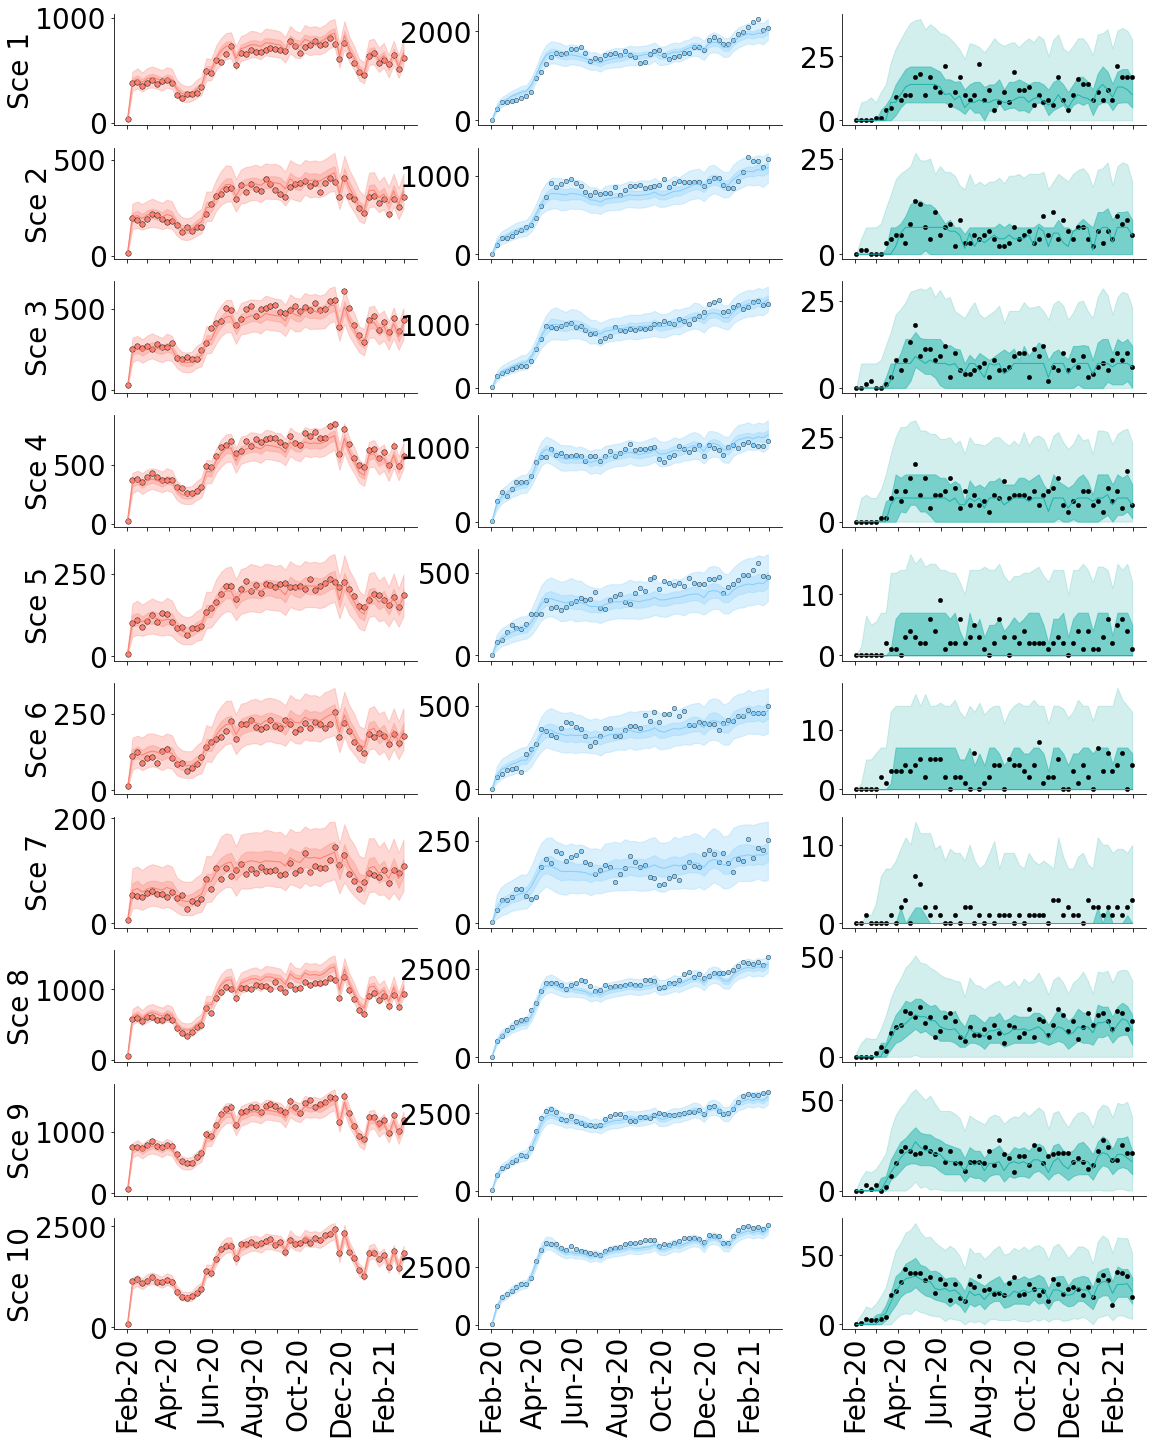

In [47]:
fig, ax = plt.subplots(10, 3, figsize=(18.5, 24.2), sharex=True)

for idx_sce in range(10):
    scenario_this = scenarios_dicts[idx_sce]
    gamma_truth   = scenario_this["params_truth"][0]["gamma"]

    var_df     = obs_w_df[obs_w_df.variable=="colonized_imported"]
    mle_var_df = mle_w_df[mle_w_df.variable=="imported"]; mle_var_df = mle_var_df[mle_var_df.scenario==scenario_this["name"]]
    sns.lineplot(ax=ax[idx_sce, 0], data=mle_var_df, x="date", y="median", linewidth=1, color="salmon")
    ax[idx_sce, 0].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
    ax[idx_sce, 0].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="salmon", alpha=0.3)
    sns.scatterplot(ax=ax[idx_sce, 0], data=var_df[var_df.scenario==scenario_this["name"]], x="date", y="value", label="Imported Data", edgecolor="k", facecolor="salmon", s=30)


    var_df     = obs_w_df[obs_w_df.variable=="nosocomial"]
    mle_var_df = mle_w_df[mle_w_df.variable=="nosocomial"]; mle_var_df = mle_var_df[mle_var_df.scenario==scenario_this["name"]]
    sns.lineplot(ax=ax[idx_sce, 1], data=mle_var_df, x="date", y="median", linewidth=1, color="lightskyblue")
    ax[idx_sce, 1].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightskyblue", alpha=0.3, label="Nosocomial Sim.")
    ax[idx_sce, 1].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightskyblue", alpha=0.3)
    sns.scatterplot(ax=ax[idx_sce, 1], data=var_df[var_df.scenario==scenario_this["name"]], x="date", y="value", label="Nosocomial Data", s=20, edgecolor="k", facecolor="lightskyblue")


    var_df     = obs_w_df[obs_w_df.variable=="positive"]
    mle_var_df = mle_w_df[mle_w_df.variable=="positive"]; mle_var_df = mle_var_df[mle_var_df.scenario==scenario_this["name"]]


    sns.lineplot(ax=ax[idx_sce, 2], data=mle_var_df[mle_var_df.scenario==scenario_this["name"]], x="date", y="median", linewidth=1, color="lightseagreen")
    ax[idx_sce, 2].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightseagreen", alpha=0.2)
    ax[idx_sce, 2].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightseagreen", alpha=0.5)
    sns.scatterplot(ax=ax[idx_sce, 2], data=var_df[var_df.scenario==scenario_this["name"]], x="date", y="value", s=20, edgecolor="k", facecolor="k", label="Used for optimization")

for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend().remove()
        #axi.legend(title="Type acquisition", bbox_to_anchor=(0.0, 2.2), ncol=2, loc="upper left")

#sx_ticks_pos    = (18293.0, 0, 18322.0, 0,18353.0, 0,18383.0, 0,18414.0, 0,18444.0, 0,18475.0, 0,18506.0, 0,18536.0, 0,18567.0, 0,18597.0, 0,18628.0, 0,18659.0, 0,18687.0)
x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

for idx_sce in range(len(scenarios_dicts)):
    ax[idx_sce, 0].set_ylabel(f"Sce {idx_sce+1}", rotation=90, labelpad=0)

#fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.6, wspace=0.45, hspace=0.25)

path_to_save  = os.path.join(path_to_ms_figs, "SyntheticHospitalFit.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/2293759451.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/2293759451.py:54: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


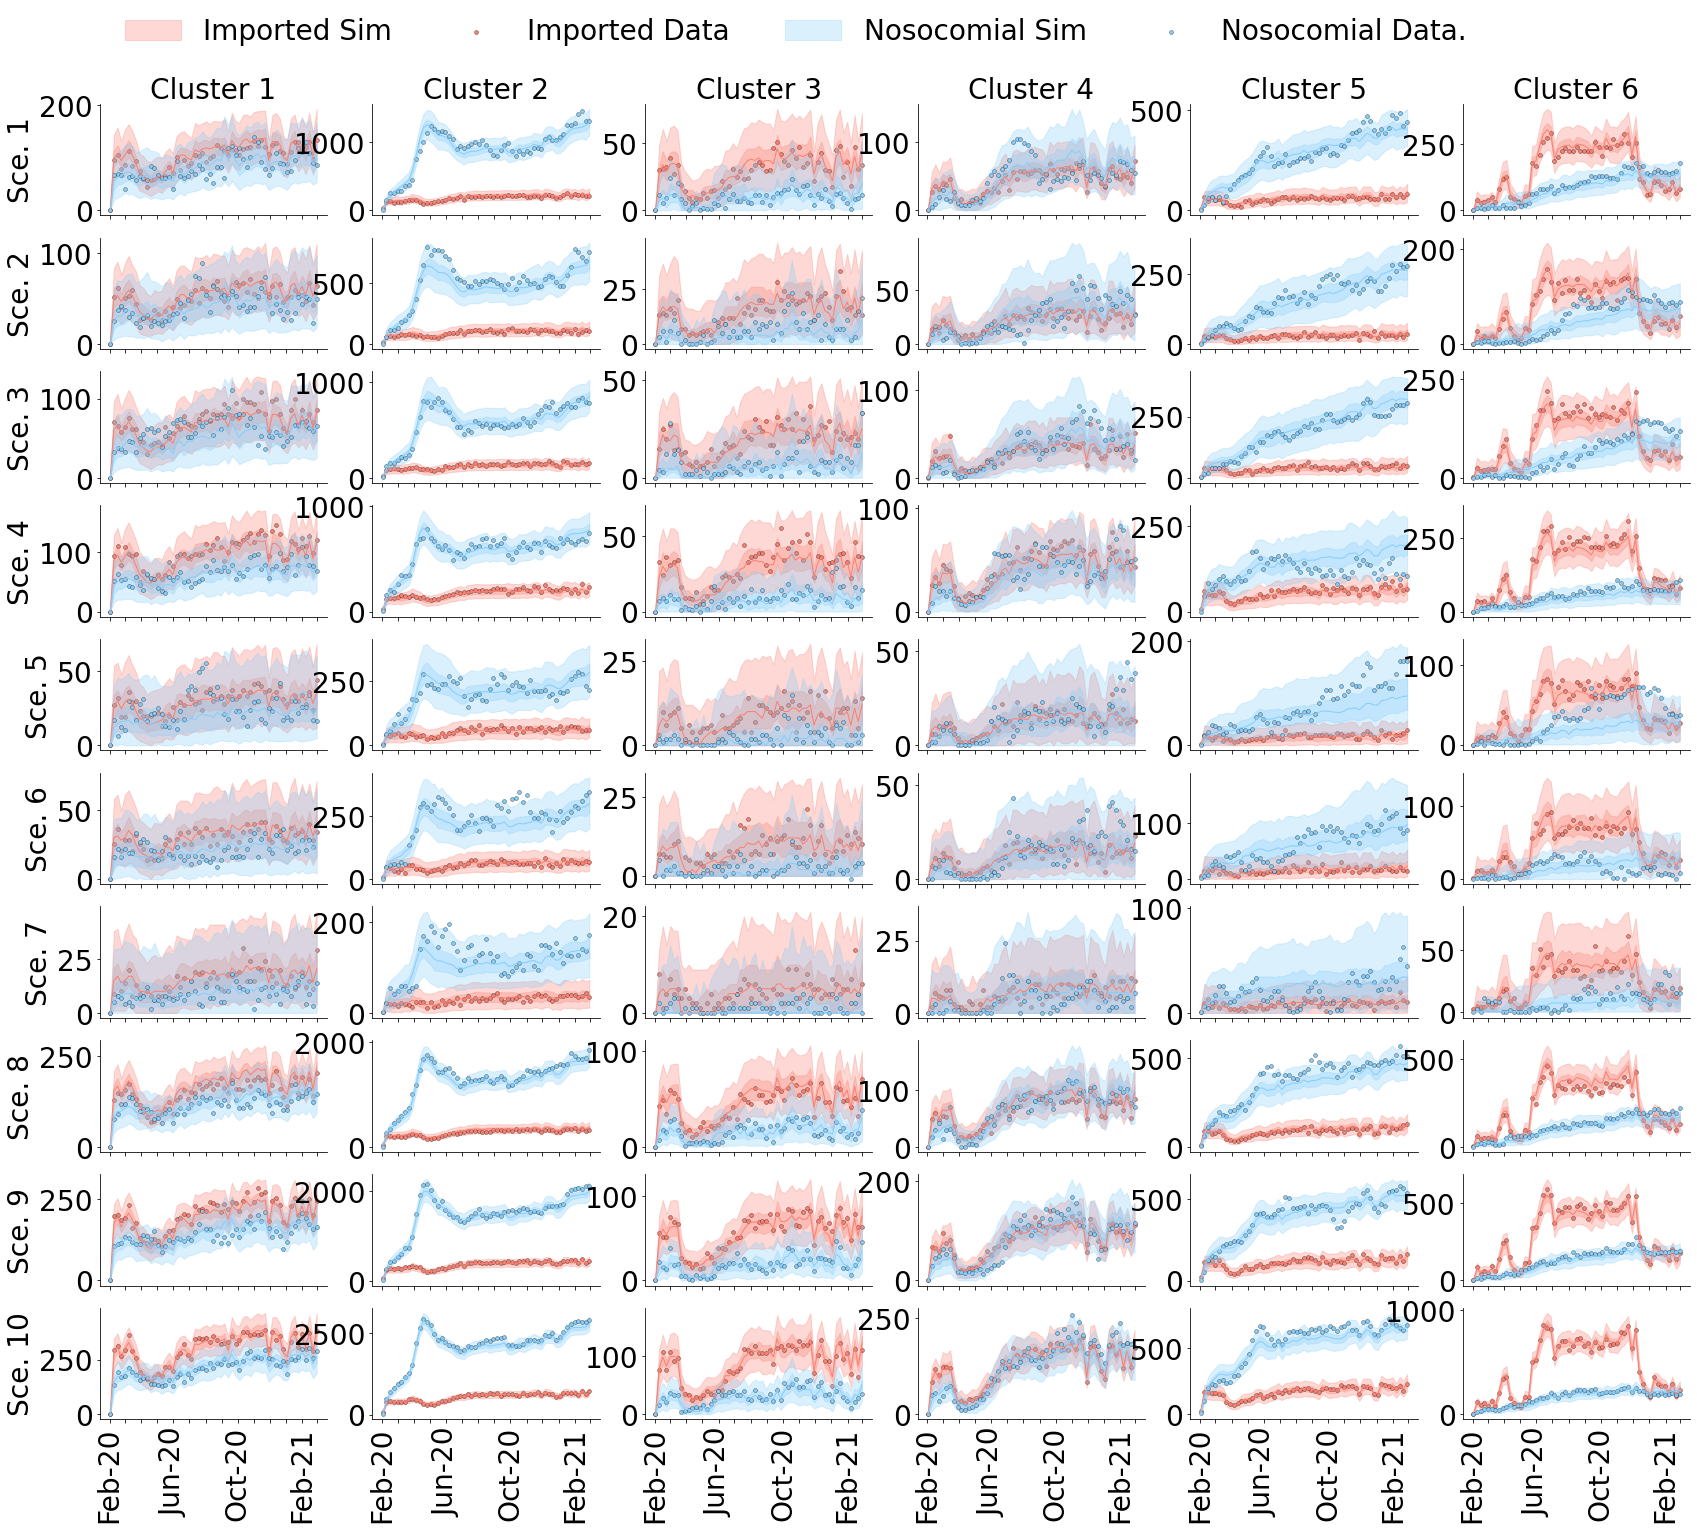

In [17]:

fig, ax = plt.subplots(len(scenarios_dicts), abm_settings["num_wards_chunks"], figsize=(28.5, 24.2), sharex=True)
for idx_chunk in range(abm_settings["num_wards_chunks"]):
    for idx_sce in range(len(scenarios_dicts)):

        var_df = obs_w_df[obs_w_df.variable=="ward_chunk_colonized_imported"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.cluster==idx_chunk+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_imported"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]


        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df, x="date", y="median", linewidth=1, color="salmon")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="salmon", alpha=0.3)

        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df, x="date", y="value", label="Imported Data", edgecolor="k", facecolor="salmon", s=15)

        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_nosocomial"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.cluster==idx_chunk+1]
        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_nosocomial"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df, x="date", y="median", linewidth=1, color="lightskyblue")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightskyblue", alpha=0.3, label="Nosocomial Sim")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightskyblue", alpha=0.3)
        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df, x="date", y="value", label="Nosocomial Data.", s=15, edgecolor="k", facecolor="lightskyblue")

for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend(bbox_to_anchor=(0.0, 2.0), ncol=4, loc="upper left", frameon=False)

x_ticks_pos    = (18293.0, 0, 18322.0, 0,18353.0, 0,18383.0, 0,18414.0, 0,18444.0, 0,18475.0, 0,18506.0, 0,18536.0, 0,18567.0, 0,18597.0, 0,18628.0, 0,18659.0, 0,18687.0)
x_ticks_labels = ['Feb-20','','','','Jun-20','','','','Oct-20','','','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

for idx_chunk in range(abm_settings["num_wards_chunks"]):
    ax[0, idx_chunk].set_title(f"Cluster {idx_chunk+1}")


for idx_sce in range(len(scenarios_dicts)):
    ax[idx_sce, 0].set_ylabel(f"Sce. {idx_sce+1}", rotation=90)

plt.tight_layout()

path_to_save  = os.path.join(path_to_ms_figs, "SyntheticFitClusterLevel.png")
fig.savefig(path_to_save, dpi=300, transparent=True)



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/3212777665.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)


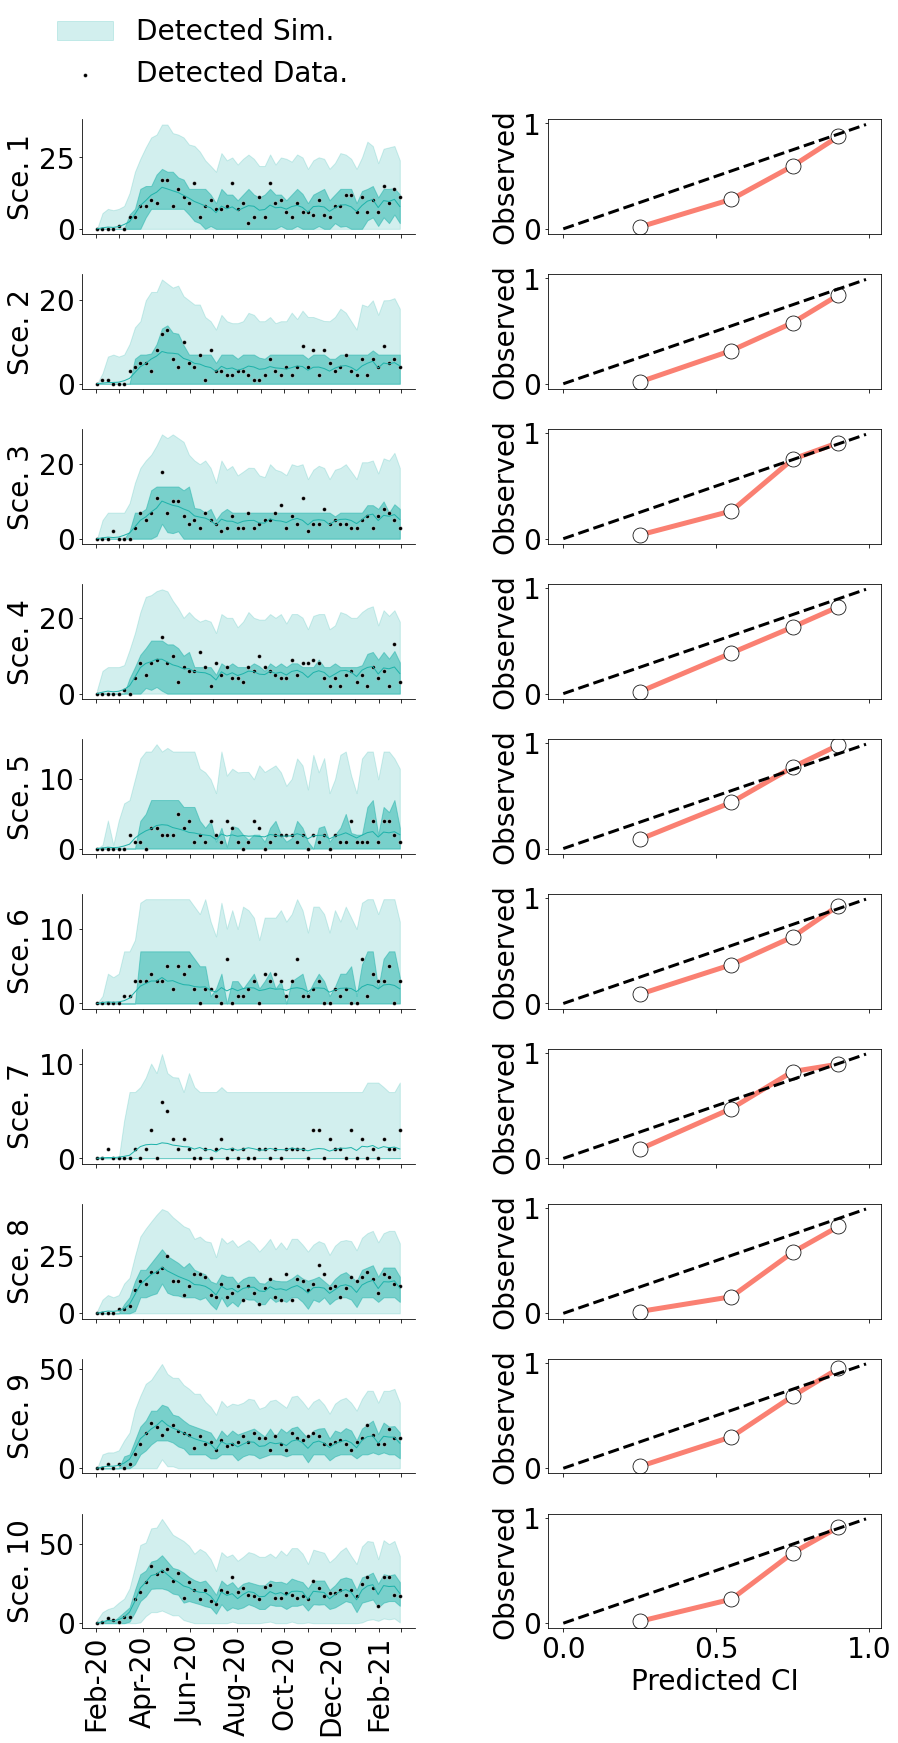

In [18]:

identity       = np.arange(0,1, 0.01)
cal_this_df    = calibration_df[calibration_df.variable=="positive"]

fig, ax = plt.subplots(len(scenarios_dicts), 2, figsize=(18.5, 26.2), sharex="col")

for idx_scenario in range(len(scenarios_dicts)):

    cal_plt_df    = cal_this_df[cal_this_df.scenario==f"scenario{idx_scenario+1}"]
    sns.lineplot(ax=ax[idx_scenario, 1], data=cal_plt_df[cal_plt_df.cluster_id==1], x="confidence", y="proportion_inside", marker="o", lw=5, ms=15, mfc="w", mec="k", color="salmon")
    ax[idx_scenario, 1].plot(identity, identity, color="k", linestyle="--", lw=3, label="y=x")
    ax[idx_scenario, 1].set_xlabel("Predicted CI")
    ax[idx_scenario, 1].set_ylabel("Observed")
    ax[idx_scenario, 1].legend().remove()


    var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_positive"]
    var_df     = var_df[var_df.scenario==scenarios_dicts[idx_scenario]["name"]]
    var_df     = var_df[var_df.cluster==2]
    mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
    mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_scenario]["name"]]
    mle_var_df = mle_var_df[mle_var_df.cluster==2]

    sns.lineplot(ax=ax[idx_scenario, 0], data=mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_scenario]["name"]], x="date", y="mean", linewidth=1, color="lightseagreen")
    ax[idx_scenario, 0].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightseagreen", alpha=0.2, label="Detected Sim.")
    ax[idx_scenario, 0].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightseagreen", alpha=0.5)
    sns.scatterplot(ax=ax[idx_scenario, 0], data=var_df[var_df.scenario==scenarios_dicts[idx_scenario]["name"]], x="date", y="value", s=15, edgecolor="w", facecolor="black", label="Detected Data.")

    format_axis(ax[idx_scenario, 0], week=False)
    ax[idx_scenario, 0].set_ylabel(f"Sce. {idx_scenario+1}", rotation=90)
    #ax[idx_scenario, 0].set_ylabel(None)
    ax[idx_scenario, 0].set_xlabel(None)

    if idx_scenario>0:
        ax[idx_scenario, 0].legend().remove()
    else:
        ax[idx_scenario, 0].legend(bbox_to_anchor=(-0.15, 2.1), ncol=1, loc="upper left", frameon=False)

x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

plt.tight_layout()

fig.subplots_adjust(left=0.2, bottom=0.1, right=0.8, top=0.9, wspace=0.4, hspace=0.35)
path_to_save  = os.path.join(path_to_ms_figs, "PositivesCalibrationPlot.png")
fig.savefig(path_to_save, dpi=300, transparent=True)



/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/3077264260.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/3077264260.py:63: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


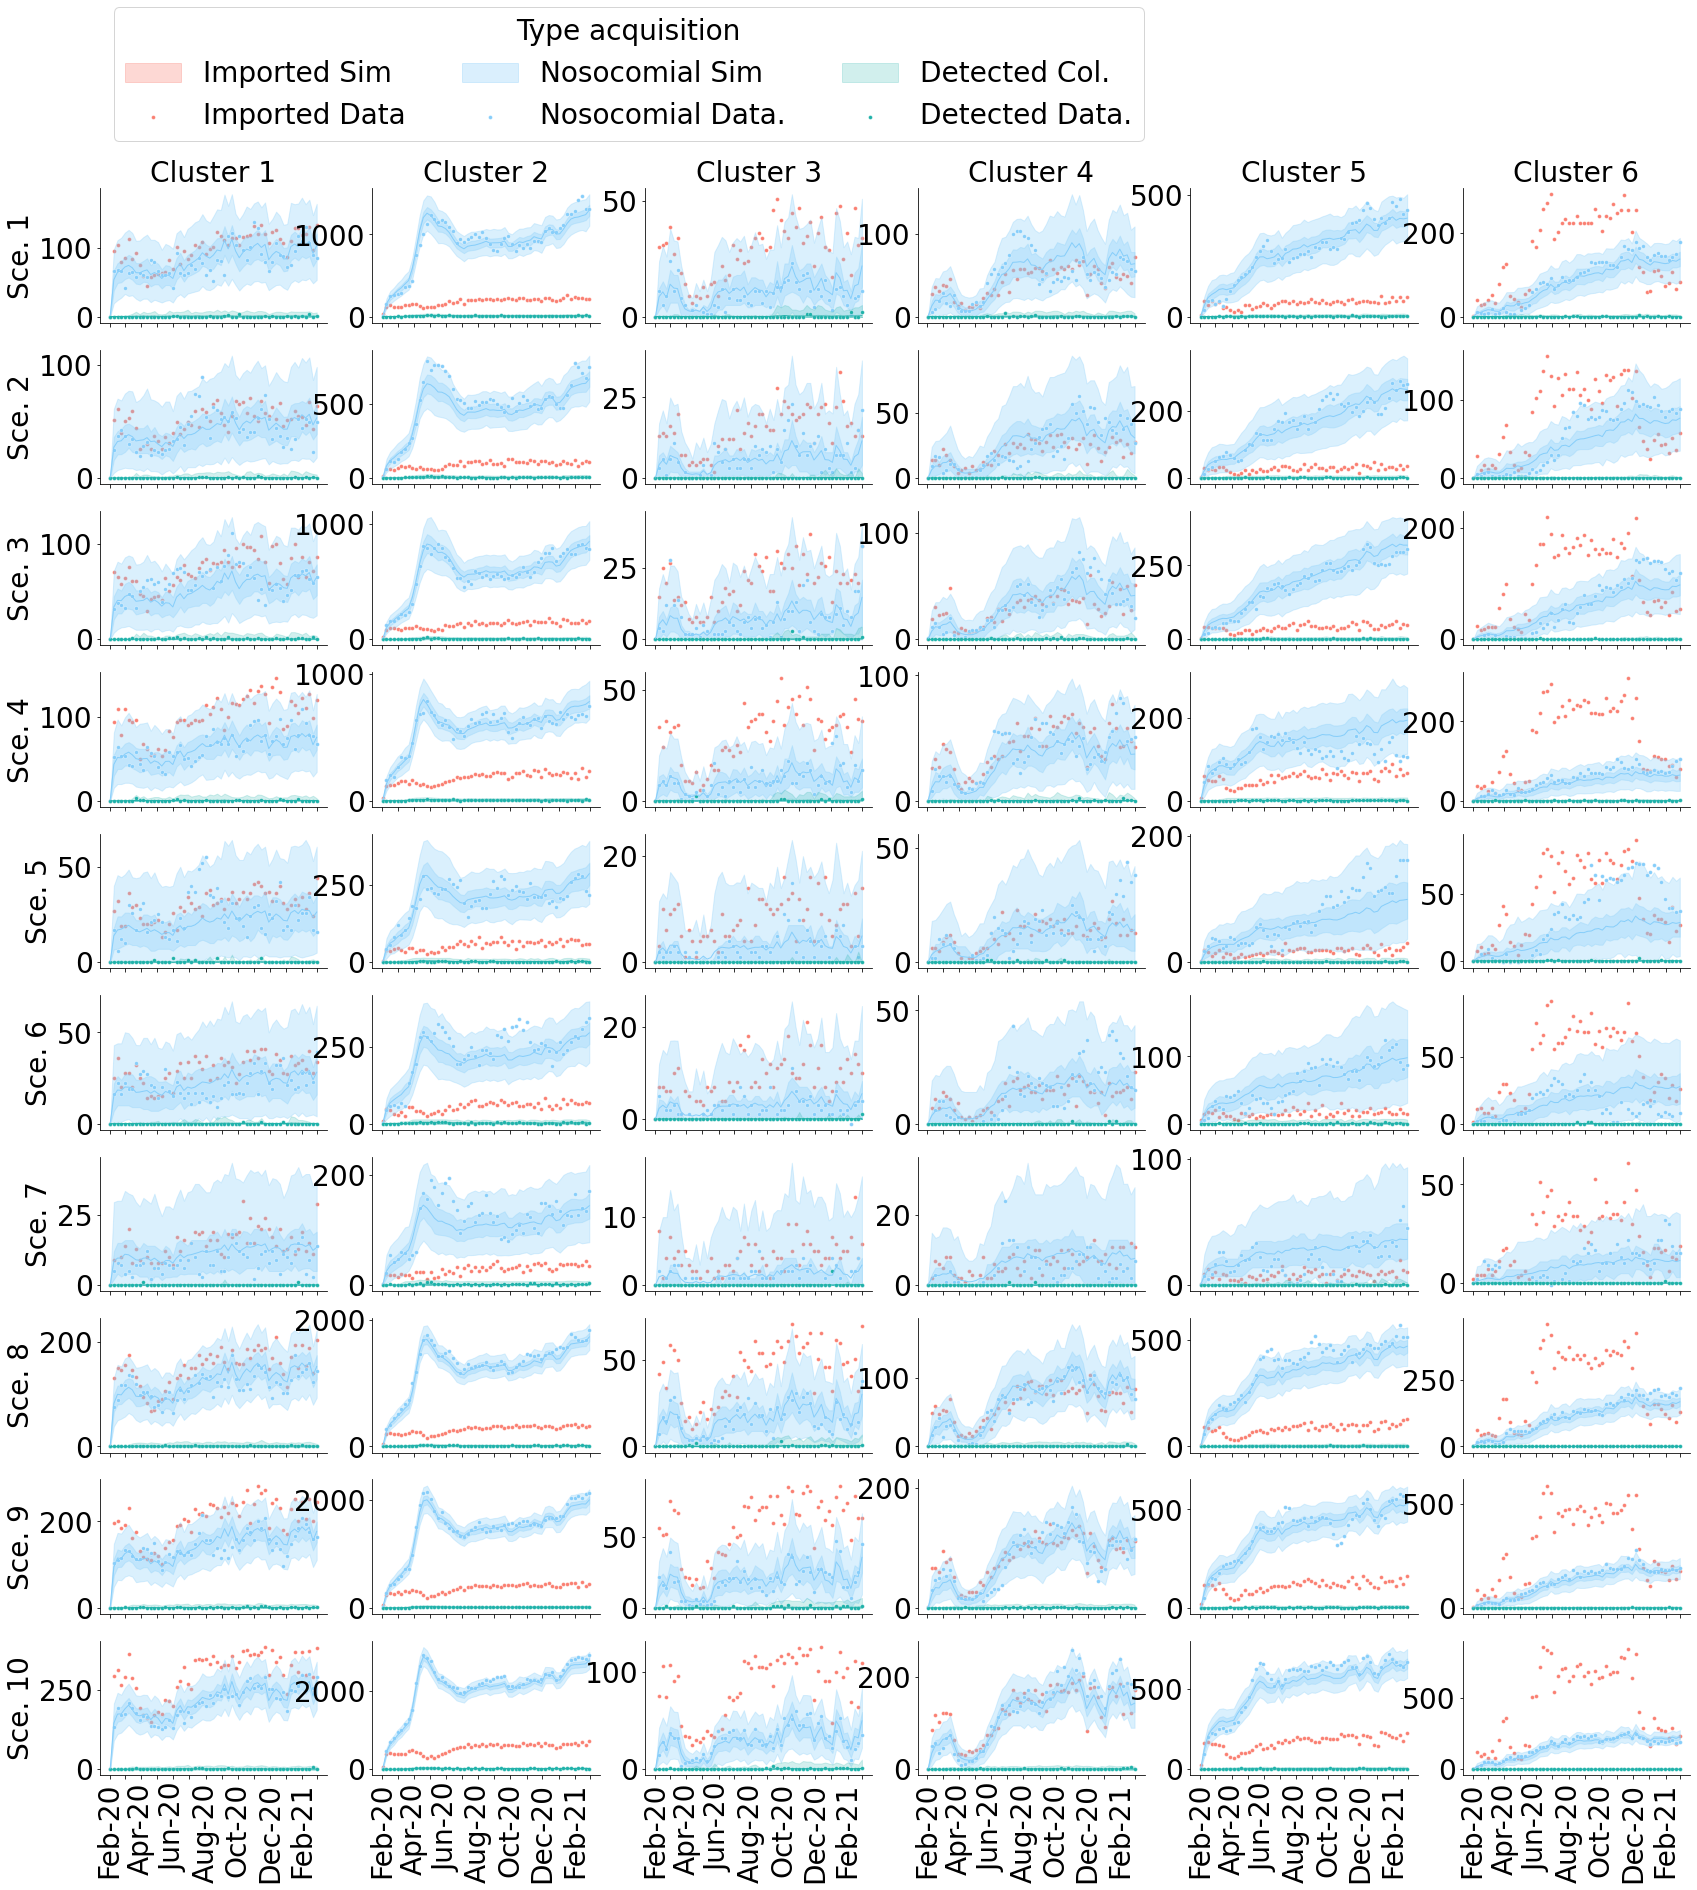

In [19]:

fig, ax = plt.subplots(len(scenarios_dicts), abm_settings["num_wards_chunks"], figsize=(28.5, 29.2), sharex=True)
for idx_chunk in range(abm_settings["num_wards_chunks"]):
    for idx_sce in range(len(scenarios_dicts)):

        var_df = obs_w_df[obs_w_df.variable=="ward_chunk_colonized_imported"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.cluster==idx_chunk+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_colonized_imported"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]


        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df, x="date", y="mean", linewidth=1, color="salmon")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="salmon", alpha=0.3, label="Imported Sim")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="salmon", alpha=0.3)

        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df, x="date", y="value", label="Imported Data", edgecolor="w", facecolor="salmon", s=15)

        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_nosocomial"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.cluster==idx_chunk+1]
        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_nosocomial"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df, x="date", y="mean", linewidth=1, color="lightskyblue")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightskyblue", alpha=0.3, label="Nosocomial Sim")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightskyblue", alpha=0.3)
        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df, x="date", y="value", label="Nosocomial Data.", s=15, edgecolor="w", facecolor="lightskyblue")

        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_positive"]
        var_df     = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df     = var_df[var_df.cluster==idx_chunk+1]
        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]], x="date", y="mean", linewidth=1, color="lightseagreen")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightseagreen", alpha=0.2, label="Detected Col.")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightseagreen", alpha=0.5)
        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]], x="date", y="value", s=15, edgecolor="w", facecolor="lightseagreen", label="Detected Data.")

for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend(title="Type acquisition", bbox_to_anchor=(0.0, 2.45), ncol=3, loc="upper left")

x_ticks_pos    = (18293.0, 0, 18322.0, 0,18353.0, 0,18383.0, 0,18414.0, 0,18444.0, 0,18475.0, 0,18506.0, 0,18536.0, 0,18567.0, 0,18597.0, 0,18628.0, 0,18659.0, 0,18687.0)
x_ticks_labels = ['Feb-20','','Apr-20','','Jun-20','','Aug-20','','Oct-20','','Dec-20','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

for idx_chunk in range(abm_settings["num_wards_chunks"]):
    ax[0, idx_chunk].set_title(f"Cluster {idx_chunk+1}")

for idx_sce in range(len(scenarios_dicts)):
    ax[idx_sce, 0].set_ylabel(f"Sce. {idx_sce+1}", rotation=90)

plt.tight_layout()

path_to_save  = os.path.join(path_to_ms_figs, "just_the_legend.png")
fig.savefig(path_to_save, dpi=300, transparent=True)



In [23]:
date_format_display = '%d-%b-%y'
dates_axis = np.unique(dates_w_sun)
dates_axis = pd.DataFrame(dates_axis)[0].map(lambda x: x.strftime(date_format_display)).values


mle_chunk_col_imported_hm_df  = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); mle_chunk_col_imported_hm_df.index.name = "cluster"
mle_chunk_nosocomial_hm_df    = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); mle_chunk_nosocomial_hm_df.index.name   = "cluster"
mle_chunk_positive_hm_df      = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); mle_chunk_positive_hm_df.index.name     = "cluster"

data_chunk_col_imported_hm_df = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); data_chunk_col_imported_hm_df.index.name = "cluster"
data_chunk_nosocomial_hm_df   = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); data_chunk_nosocomial_hm_df.index.name   = "cluster"
data_chunk_positive_hm_df     = pd.DataFrame(index=range(abm_settings["num_wards_chunks"]), columns=dates_axis); data_chunk_positive_hm_df.index.name     = "cluster"

for idx_chunk in range(abm_settings["num_wards_chunks"]):
    for idx_sce in range(len(scenarios_dicts)):
        var_df = obs_w_df[obs_w_df.variable=="ward_chunk_colonized_imported"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.cluster==idx_chunk+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_imported"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        mle_chunk_col_imported_hm_df.loc[idx_chunk]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_chunk_col_imported_hm_df.loc[idx_chunk] = np.maximum(var_df["value"], 0).astype(int).values


        ######################################################################## 
        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_nosocomial"]
        var_df     = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df     = var_df[var_df.cluster==idx_chunk+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_nosocomial"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        mle_chunk_nosocomial_hm_df.loc[idx_chunk]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_chunk_nosocomial_hm_df.loc[idx_chunk] = np.maximum(var_df["value"], 0).astype(int).values


        ######################################################################## 
        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_positive"]
        var_df     = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df     = var_df[var_df.cluster==idx_chunk+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        mle_chunk_positive_hm_df.loc[idx_chunk]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_chunk_positive_hm_df.loc[idx_chunk] = np.maximum(var_df["value"], 0).astype(int).values

mle_chunk_col_impormle_chunk_col_imported_hm_df = mle_chunk_col_imported_hm_df.fillna(0)
data_chunk_col_imported_hm_df                   = data_chunk_col_imported_hm_df.fillna(0)
mle_chunk_positive_hm_df                        = mle_chunk_positive_hm_df.fillna(0)
data_chunk_positive_hm_df                       = data_chunk_positive_hm_df.fillna(0)


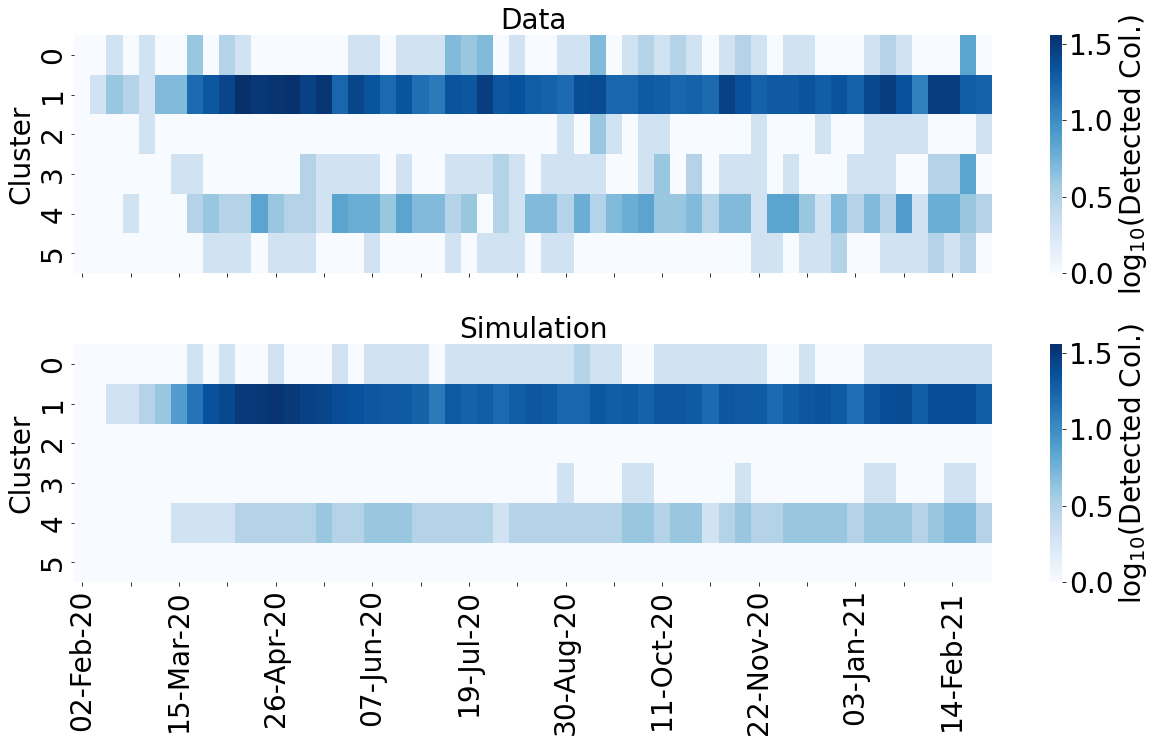

In [26]:
max_value = np.log10(np.maximum( data_chunk_positive_hm_df.max().max(), mle_chunk_positive_hm_df.max().max()))

fig_dims = figure_size_setting(1600)
fig, ax = plt.subplots(2, 1, figsize=fig_dims, sharex=True, sharey=True)
g = sns.heatmap(ax=ax[0], data=np.log10(data_chunk_positive_hm_df+1), cmap=sns.color_palette("Blues", as_cmap=True),  vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})
ax[0].set_xlabel(None)

g = sns.heatmap(ax=ax[1], data=np.log10(mle_chunk_positive_hm_df+1), cmap=sns.color_palette("Blues", as_cmap=True), vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})
ax[0].set_ylabel("Cluster")
ax[1].set_ylabel("Cluster")
ax[1].set_xlabel(None)

ax[0].set_title("Data")
ax[1].set_title("Simulation")

x_tick_labels= ['02-Feb-20','','15-Mar-20','', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '', '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']
ax[1].set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.subplots_adjust( hspace=0.3 )

path_to_save  = os.path.join(path_to_ms_figs, "HeatmapsMeanCluster_DataVsSim.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/2871237907.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[-1, 0].set_xticklabels(x_ticks_labels)
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_24397/2871237907.py:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


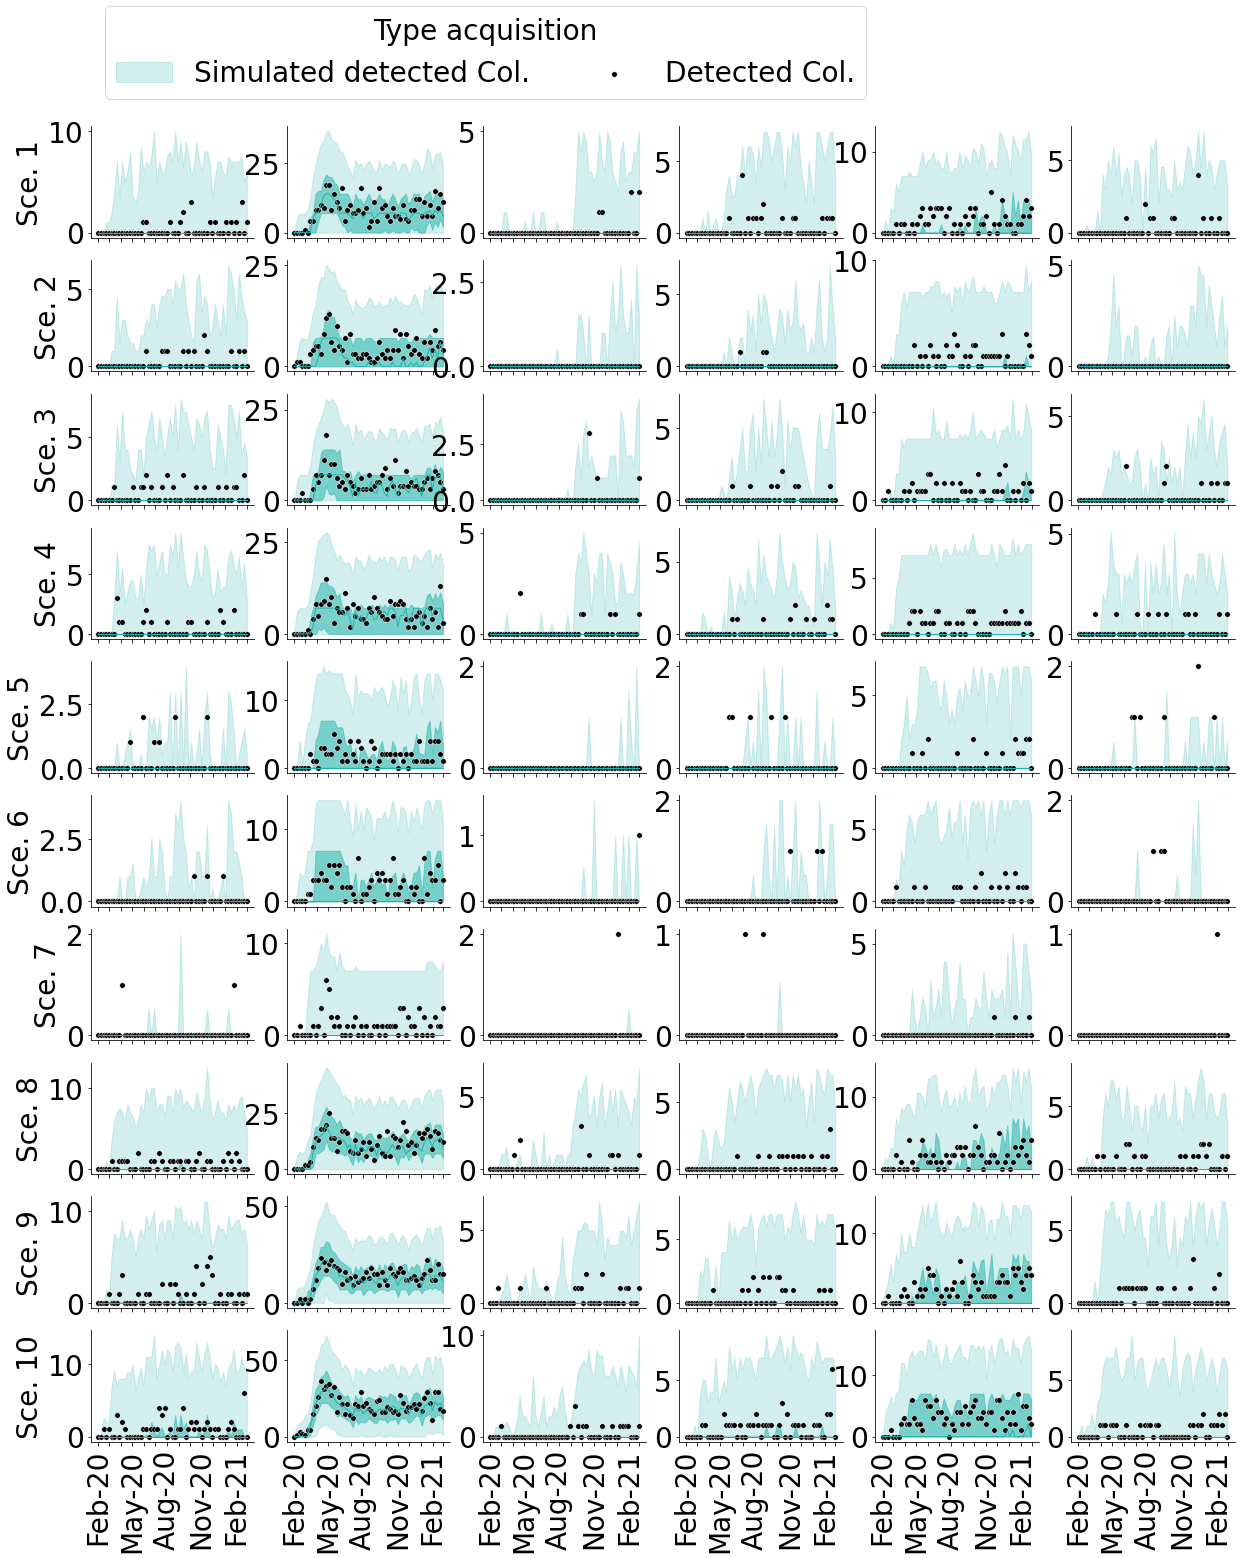

In [49]:

fig, ax = plt.subplots(len(scenarios_dicts), abm_settings["num_wards_chunks"], figsize=(20.5, 24.2), sharex=True)

for idx_chunk in range(abm_settings["num_wards_chunks"]):
    for idx_sce in range(len(scenarios_dicts)):

        var_df     = obs_w_df[obs_w_df.variable=="ward_chunk_positive"]
        var_df     = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df     = var_df[var_df.cluster==idx_chunk+1]
        mle_var_df = mle_w_df[mle_w_df.variable=="ward_chunk_positive"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.cluster==idx_chunk+1]

        sns.lineplot(ax=ax[idx_sce, idx_chunk], data=mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]], x="date", y="median", linewidth=1, color="lightseagreen")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_95, mle_var_df.high_95, color="lightseagreen", alpha=0.2, label="Simulated detected Col.")
        ax[idx_sce, idx_chunk].fill_between(mle_var_df.date, mle_var_df.low_50, mle_var_df.high_50, color="lightseagreen", alpha=0.5)
        sns.scatterplot(ax=ax[idx_sce, idx_chunk], data=var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]], x="date", y="value", s=30, edgecolor="w", facecolor="k", label="Detected Col.")

for idx_axi, axi in enumerate(ax.flatten()):
    format_axis(axi, week=False)
    axi.set_ylabel(None)
    axi.set_xlabel(None)
    if idx_axi>0:
        axi.legend().remove()
    else:
        axi.legend(title="Type acquisition", bbox_to_anchor=(0.0, 2.2), ncol=2, loc="upper left")

x_ticks_labels = ['Feb-20','','','May-20','','','Aug-20','','','Nov-20','','','Feb-21','']
ax[-1, 0].set_xticklabels(x_ticks_labels)

for idx_sce in range(len(scenarios_dicts)):
    ax[idx_sce, 0].set_ylabel(f"Sce. {idx_sce+1}", rotation=90)

plt.tight_layout()

path_to_save  = os.path.join(path_to_ms_figs, "PositivesCluster_Scenarios.png")
fig.savefig(path_to_save, dpi=300, transparent=True)


# Per Ward heatmaps

# need to load the variables per ward again.

In [31]:
from SCENARIOS import return_scenarios_paper
from itertools import chain

scenarios_dicts = return_scenarios_paper()

pos_all_df = []
obs_all_df = []

def create_variable_df(abm_settings, samples, variable_name):
    df             = pd.DataFrame(columns=["date", "value", "variable"])
    df["value"]    = samples
    df["date"]     = abm_settings["dates"]
    df["variable"] = [variable_name]*len(abm_settings["dates"])
    return df

mle_df = []
obs_df = []

calibration_df = []
for idx_scenario in tqdm(range(len(scenarios_dicts))):

    scenario             = scenarios_dicts[idx_scenario]
    scenario_params      = scenario["params_truth"][0]
    scenario_params_name = scenario["name"]
    params_dict          = scenario_params

    path_to_save_pid = os.path.join(path_to_save_samples_synthetic_test, scenario_params_name)

    sim_samples = np.load(os.path.join(path_to_save_pid, f'mle_simulation_{run_id}.npz'))

    # Samples from MLE
   # colonized_imported_mle  = sim_samples["colonized_imported"];      colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
   # nosocomial_mle          = sim_samples["nosocomial"];              nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
   # colonized_mle           = sim_samples["colonized"];               colonized_mle_df          = create_df_response(colonized_mle.T         , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
   # positive_mle            = sim_samples["positive"];                positive_mle_df           = create_df_response(positive_mle.T          , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()

    # # Samples from MLE
    colonized_imported_mle  = sim_samples["ward_chunk_imported"].sum(-2);      colonized_imported_mle_df = create_df_response(colonized_imported_mle.T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    colonized_mle           = sim_samples["ward_chunk_colonized"].sum(-2);               colonized_mle_df          = create_df_response(colonized_mle.T         , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()
    positive_mle            = sim_samples["ward_chunk_positive"].sum(-2);                positive_mle_df           = create_df_response(positive_mle.T          , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()

    nosocomial_mle          = sim_samples["ward_chunk_colonized"].sum(-2)-sim_samples["ward_chunk_imported"].sum(-2);              nosocomial_mle_df         = create_df_response(nosocomial_mle.T        , time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index()


    ward_colonized_imp_mle  = sim_samples["ward_colonized"]; ward_colonized_imp_mle_df = pd.concat([create_df_response(ward_colonized_imp_mle[:,idx,:].T, time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_nosocomial_mle     = sim_samples["ward_nosocomial"];         ward_nosocomial_mle_df    = pd.concat([create_df_response(ward_nosocomial_mle[:,idx,:].T,    time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_colonized_mle      = sim_samples["ward_colonized"];          ward_colonized_mle_df     = pd.concat([create_df_response(ward_colonized_mle[:,idx,:].T,     time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])
    ward_positive_mle       = sim_samples["ward_positive"];           ward_positive_mle_df      = pd.concat([create_df_response(ward_positive_mle[:,idx,:].T,      time=len(abm_settings["dates"]), date_init ='2020-02-01').reset_index() for idx in range(abm_settings["num_wards"]) ])

    ward_colonized_imp_mle_df["ward"] =  list(chain(*[[idx_ward+1]*len(abm_settings["dates"]) for idx_ward in range(abm_settings["num_wards"])])); ward_colonized_imp_mle_df["variable"] = "ward_colonized_imported"
    ward_nosocomial_mle_df["ward"]    =  list(chain(*[[idx_ward+1]*len(abm_settings["dates"]) for idx_ward in range(abm_settings["num_wards"])])); ward_nosocomial_mle_df["variable"]    = "ward_nosocomial"
    ward_colonized_mle_df["ward"]     =  list(chain(*[[idx_ward+1]*len(abm_settings["dates"]) for idx_ward in range(abm_settings["num_wards"])])); ward_colonized_mle_df["variable"]     = "ward_colonized"
    ward_positive_mle_df["ward"]      =  list(chain(*[[idx_ward+1]*len(abm_settings["dates"]) for idx_ward in range(abm_settings["num_wards"])])); ward_positive_mle_df["variable"]      = "ward_positive"

    nosocomial_mle_df["variable"]               = "nosocomial"
    colonized_mle_df["variable"]                = "colonized"
    positive_mle_df["variable"]                 = "positive"

    # concatenate mle results
    results_mle_df = pd.concat([colonized_mle_df, colonized_imported_mle_df, nosocomial_mle_df, positive_mle_df, ward_colonized_mle_df, ward_colonized_imp_mle_df, ward_positive_mle_df, ward_nosocomial_mle_df])
    results_mle_df["scenario"] = scenario_params_name

    ##### LOAD OBSERVATION USED FOR THE INFERENCE #####
    samples_infer                   = np.load(os.path.join(path_to_save_pid, f'simulation_infer_{run_id}.npz'))
    idx_infer                       = samples_infer['idx_use']
    colonized_imported_infer        = samples_infer["ward_colonized_imported"].sum(-2)[:len(abm_settings["dates"]),idx_infer];  colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = samples_infer["ward_positive"].sum(-2)[:len(abm_settings["dates"]),idx_infer];            nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = samples_infer["ward_colonized"].sum(-2)[:len(abm_settings["dates"]),idx_infer];           colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = samples_infer["ward_nosocomial"].sum(-2)[:len(abm_settings["dates"]),idx_infer];          positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")

    ward_colonized_imp_infer       = samples_infer["ward_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer];         ward_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_colonized_imp_infer[:,idx], variable_name="ward_colonized_imported") for idx in range(abm_settings["num_wards"])])
    ward_colonized_infer           = samples_infer["ward_colonized"][:len(abm_settings["dates"]),:,idx_infer];                  ward_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_colonized_infer[:,idx], variable_name="ward_colonized") for idx in range(abm_settings["num_wards"])])
    ward_positive_infer            = samples_infer["ward_positive"][:len(abm_settings["dates"]),:,idx_infer];                   ward_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_positive_infer[:,idx], variable_name="ward_positive") for idx in range(abm_settings["num_wards"])])

    ward_nosocomial_infer          = samples_infer["ward_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];                 ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])
    ward_nosocomial_infer          = ward_colonized_infer-ward_colonized_imp_infer;                                             ward_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_nosocomial_infer[:,idx], variable_name="ward_nosocomial") for idx in range(abm_settings["num_wards"])])

    ward_colonized_imp_df["ward"] =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_nosocomial_df["ward"]    =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_colonized_df["ward"]     =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))
    ward_positive_df["ward"]      =  list(chain(*[[int(idx+1)]*len(abm_settings["dates"]) for idx in range(abm_settings["num_wards"])]))


    ward_chunk_colonized_imp_infer  = samples_infer["chunk_colonized_imported"][:len(abm_settings["dates"]),:,idx_infer]; ward_chunk_colonized_imp_df  =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_imp_infer[:,idx_chunk], variable_name="ward_chunk_colonized_imported") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_colonized_infer      = samples_infer["chunk_colonized"][:len(abm_settings["dates"]),:,idx_infer];          ward_chunk_colonized_df      =  pd.concat([create_variable_df(abm_settings, ward_chunk_colonized_infer[:,idx_chunk], variable_name="ward_chunk_colonized") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_positive_infer       = samples_infer["chunk_positive"][:len(abm_settings["dates"]),:,idx_infer];           ward_chunk_positive_df       =  pd.concat([create_variable_df(abm_settings, ward_chunk_positive_infer[:,idx_chunk], variable_name="ward_chunk_positive") for idx_chunk in range(abm_settings["num_wards_chunks"])])

    ward_chunk_nosocomial_infer     = samples_infer["chunk_nosocomial"][:len(abm_settings["dates"]),:,idx_infer];         ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])
    ward_chunk_nosocomial_infer     = ward_chunk_colonized_infer-ward_chunk_colonized_imp_infer;                          ward_chunk_nosocomial_df     =  pd.concat([create_variable_df(abm_settings, ward_chunk_nosocomial_infer[:,idx_chunk], variable_name="ward_chunk_nosocomial") for idx_chunk in range(abm_settings["num_wards_chunks"])])

    colonized_imported_infer        = ward_chunk_colonized_imp_infer.sum(1);             colonized_imported_df  = create_variable_df(abm_settings, colonized_imported_infer, variable_name="colonized_imported")
    nosocomial_infer                = ward_chunk_nosocomial_infer.sum(1);                nosocomial_df          = create_variable_df(abm_settings, nosocomial_infer, variable_name="nosocomial")
    colonized_infer                 = ward_chunk_colonized_infer.sum(1);                 colonized_df           = create_variable_df(abm_settings, colonized_infer, variable_name="colonized")
    positive_infer                  = ward_chunk_positive_infer.sum(1);                  positive_df            = create_variable_df(abm_settings, positive_infer, variable_name="positive")

    ward_chunk_colonized_imp_df["cluster"] =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_nosocomial_df["cluster"]    =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_colonized_df["cluster"]     =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))
    ward_chunk_positive_df["cluster"]      =  list(chain(*[[int(idx_chunk+1)]*len(abm_settings["dates"]) for idx_chunk in range(abm_settings["num_wards_chunks"])]))

    observations_infer_df             = pd.concat([colonized_df, colonized_imported_df, positive_df, nosocomial_df, ward_colonized_df, ward_colonized_imp_df, ward_positive_df, ward_nosocomial_df ]) #, ward_colonized_imp_df, ward_nosocomial_df, ward_colonized_df, ward_positive_df ])
    observations_infer_df["scenario"] = scenario_params_name
    observations_infer_df["date"]     = pd.to_datetime(observations_infer_df["date"])

    mle_df.append(results_mle_df)
    obs_df.append(observations_infer_df)

    # compute calibration stats
    cal_colonization_df = compute_calibration_ward_chunks(ward_chunk_colonized_mle, ward_chunk_colonized_infer, resample="W-Sun");         cal_colonization_df["variable"] = "colonized";  cal_colonization_df["scenario"] = scenario_params_name
    cal_importation_df  = compute_calibration_ward_chunks(ward_chunk_colonized_imp_mle, ward_chunk_colonized_imp_infer, resample="W-Sun"); cal_importation_df["variable"]  = "imported";   cal_importation_df["scenario"]  = scenario_params_name
    cal_nosocomial_df   = compute_calibration_ward_chunks(ward_chunk_nosocomial_mle, ward_chunk_nosocomial_infer, resample="W-Sun");       cal_nosocomial_df["variable"]   = "nosocomial"; cal_nosocomial_df["scenario"]   = scenario_params_name
    cal_positive_df     = compute_calibration_ward_chunks(ward_chunk_positive_mle, ward_chunk_positive_infer, resample="W-Sun");           cal_positive_df["variable"]     = "positive";   cal_positive_df["scenario"]     = scenario_params_name

    calibration_df.extend([cal_colonization_df, cal_importation_df, cal_nosocomial_df, cal_positive_df])


calibration_df = pd.concat(calibration_df).reset_index()
mle_df         = pd.concat(mle_df).reset_index(drop=True)
obs_df         = pd.concat(obs_df).reset_index(drop=True)

obs_w_df = obs_df.set_index(["date", "variable", "ward", "scenario"]).unstack([1, 2, 3]).resample("W-Sun").sum().stack().stack().stack().reset_index()
mle_w_df = mle_df.set_index(["date", "variable", "ward", "scenario"]).unstack([1, 2 ,3]).resample("W-Sun").sum().stack().stack().stack().reset_index()



100%|██████████| 10/10 [04:43<00:00, 28.40s/it]


In [32]:
date_format_display      = '%d-%b-%y'
dates_axis               = np.unique(dates_w_sun)
dates_axis               = pd.DataFrame(dates_axis)[0].map(lambda x: x.strftime(date_format_display)).values

mle_col_imported_hm_df   = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); mle_col_imported_hm_df.index.name = "ward"
mle_nosocomial_hm_df     = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); mle_nosocomial_hm_df.index.name   = "ward"
mle_positive_hm_df       = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); mle_positive_hm_df.index.name     = "ward"

data_col_imported_hm_df  = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); data_col_imported_hm_df.index.name = "ward"
data_nosocomial_hm_df    = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); data_nosocomial_hm_df.index.name   = "ward"
data_positive_hm_df      = pd.DataFrame(index=range(abm_settings["num_wards"]), columns=dates_axis); data_positive_hm_df.index.name     = "ward"


for idx in range(abm_settings["num_wards"]):
    for idx_sce in range(len(scenarios_dicts)):
        var_df = obs_w_df[obs_w_df.variable=="ward_colonized_imported"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.ward==idx+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_colonized_imported"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.ward==idx+1]

        mle_col_imported_hm_df.loc[idx]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_col_imported_hm_df.loc[idx] = np.maximum(var_df["value"], 0).astype(int).values


        ######################################################################## 
        var_df = obs_w_df[obs_w_df.variable=="ward_nosocomial"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.ward==idx+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_nosocomial"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.ward==idx+1]

        mle_nosocomial_hm_df.loc[idx]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_nosocomial_hm_df.loc[idx] = np.maximum(var_df["value"], 0).astype(int).values


        ######################################################################## 
        var_df = obs_w_df[obs_w_df.variable=="ward_positive"]
        var_df = var_df[var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        var_df = var_df[var_df.ward==idx+1]

        mle_var_df = mle_w_df[mle_w_df.variable=="ward_positive"]
        mle_var_df = mle_var_df[mle_var_df.scenario==scenarios_dicts[idx_sce]["name"]]
        mle_var_df = mle_var_df[mle_var_df.ward==idx+1]

        mle_positive_hm_df.loc[idx]  = np.maximum(mle_var_df["mean"], 0).astype(int).values
        data_positive_hm_df.loc[idx] = np.maximum(var_df["value"], 0).astype(int).values

data_col_imported_hm_df             = data_col_imported_hm_df.fillna(0)
mle_col_impormle_col_imported_hm_df = mle_col_imported_hm_df.fillna(0)
mle_positive_hm_df                  = mle_positive_hm_df.fillna(0)
data_positive_hm_df                 = data_positive_hm_df.fillna(0)


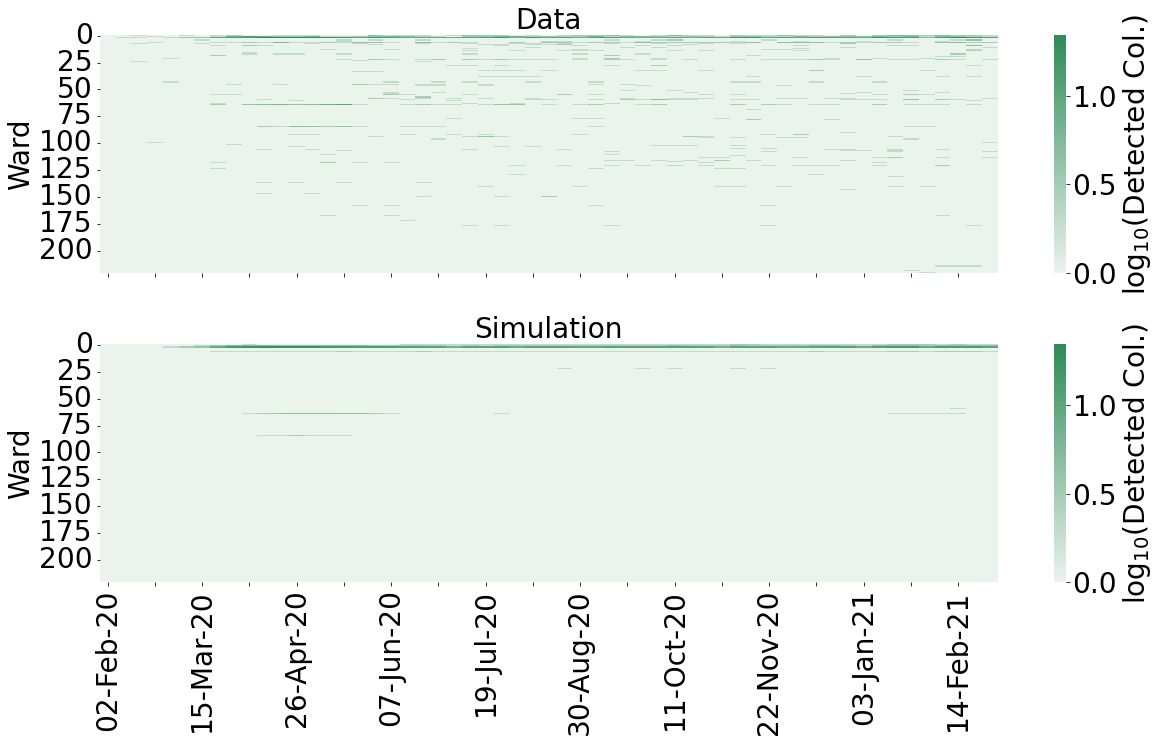

In [34]:
max_value = np.log10(np.maximum( data_positive_hm_df.max().max(), mle_positive_hm_df.max().max()))

fig_dims  = figure_size_setting(1600)
fig, ax   = plt.subplots(2, 1, figsize=fig_dims, sharex=True, sharey=True)

g         = sns.heatmap(ax=ax[0], data=np.log10(data_positive_hm_df+1), cmap=sns.light_palette("seagreen", as_cmap=True),  vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})
g         = sns.heatmap(ax=ax[1], data=np.log10(mle_positive_hm_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})

ax[0].set_xlabel(None)
ax[1].set_xlabel(None)

ax[0].set_ylabel("Ward")
ax[1].set_ylabel("Ward")

ax[0].set_title("Data")
ax[1].set_title("Simulation")

#x_tick_labels=['02-Feb','','01-Mar','','29-Mar','','26-Apr','','24-May','','21-Jun','','19-Jul','','16-Aug','','13-Sep','','11-Oct','','08-Nov','','06-Dec','','03-Jan','','31-Jan','','28-Feb']
x_tick_labels= ['02-Feb-20','','15-Mar-20','', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '', '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']
ax[1].set_xticklabels(x_tick_labels)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

path_to_save  = os.path.join(path_to_ms_figs, "HeatmapsWardMean_DataVsSim.png")
fig.savefig(path_to_save, dpi=300, transparent=True)

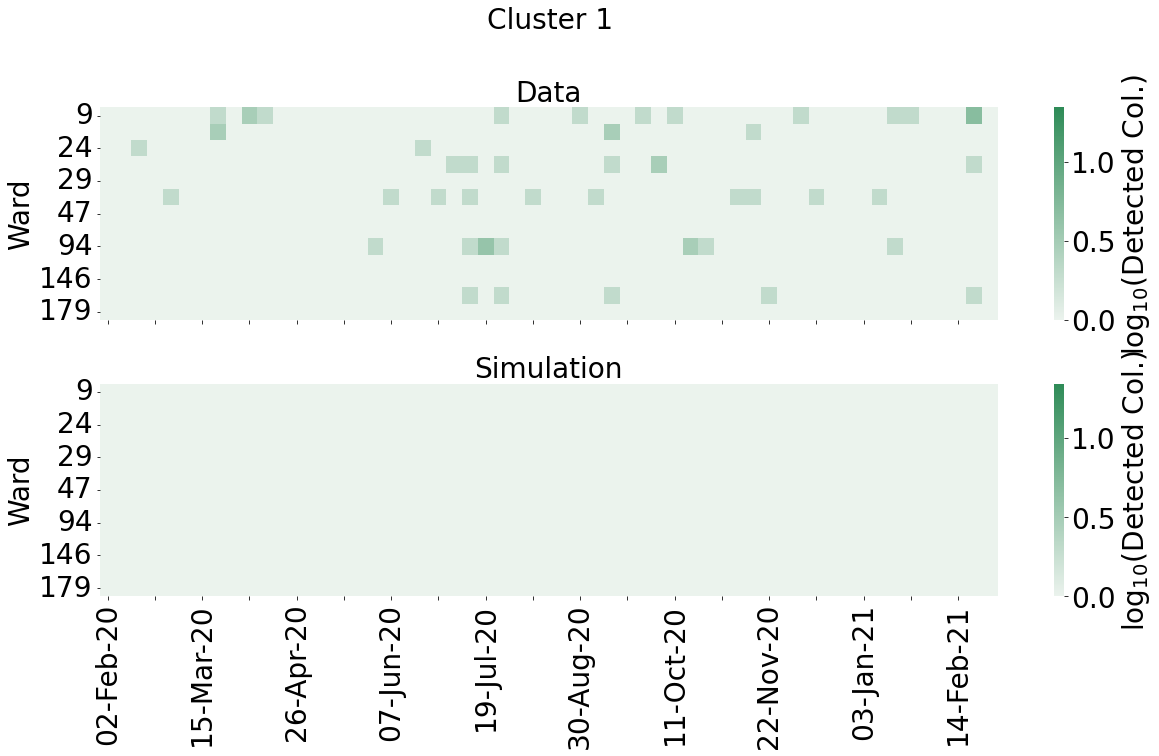

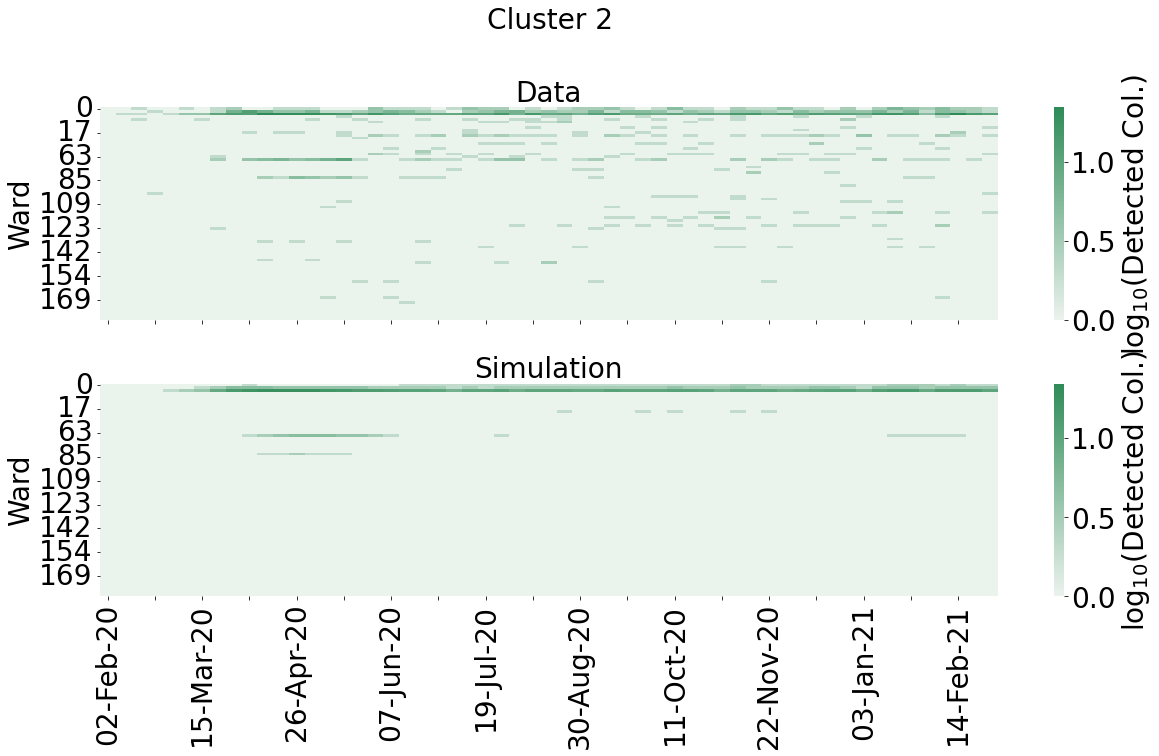

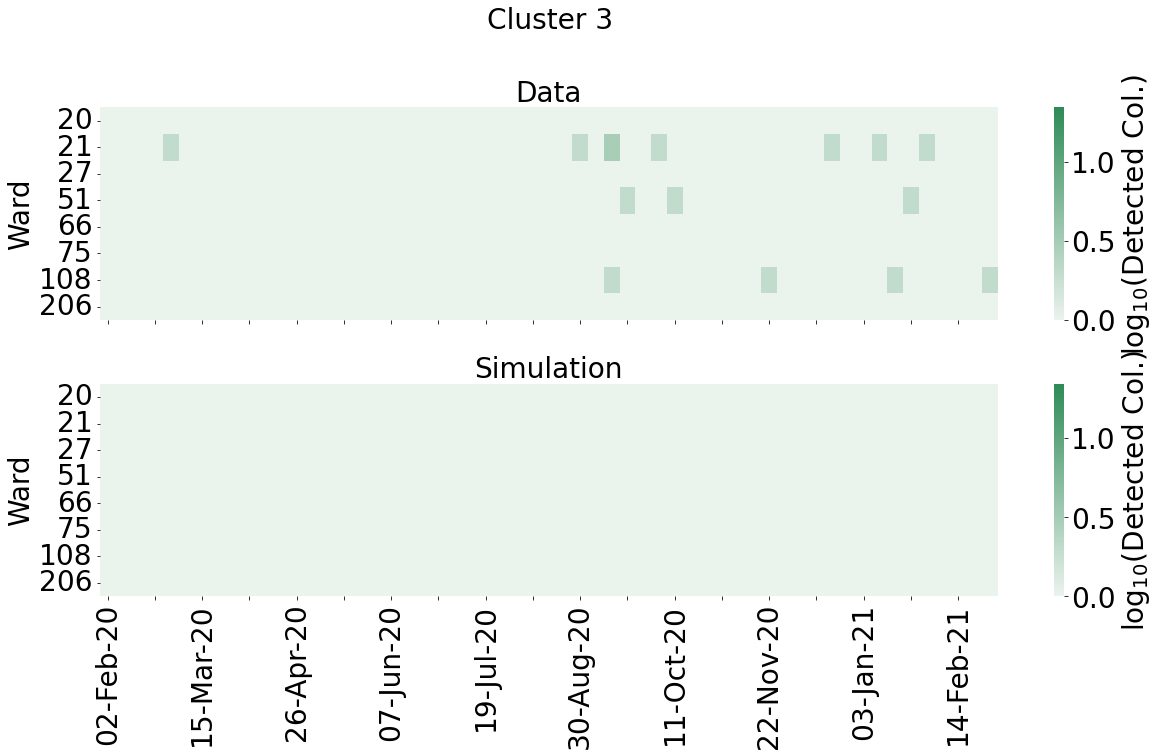

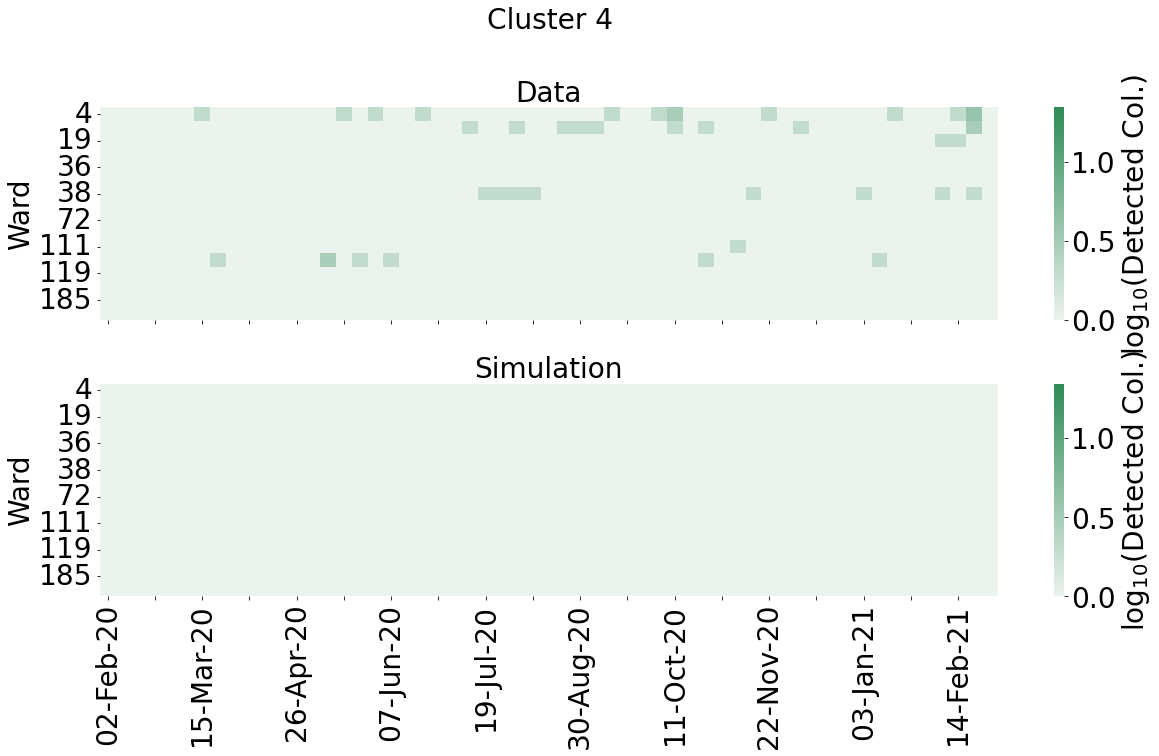

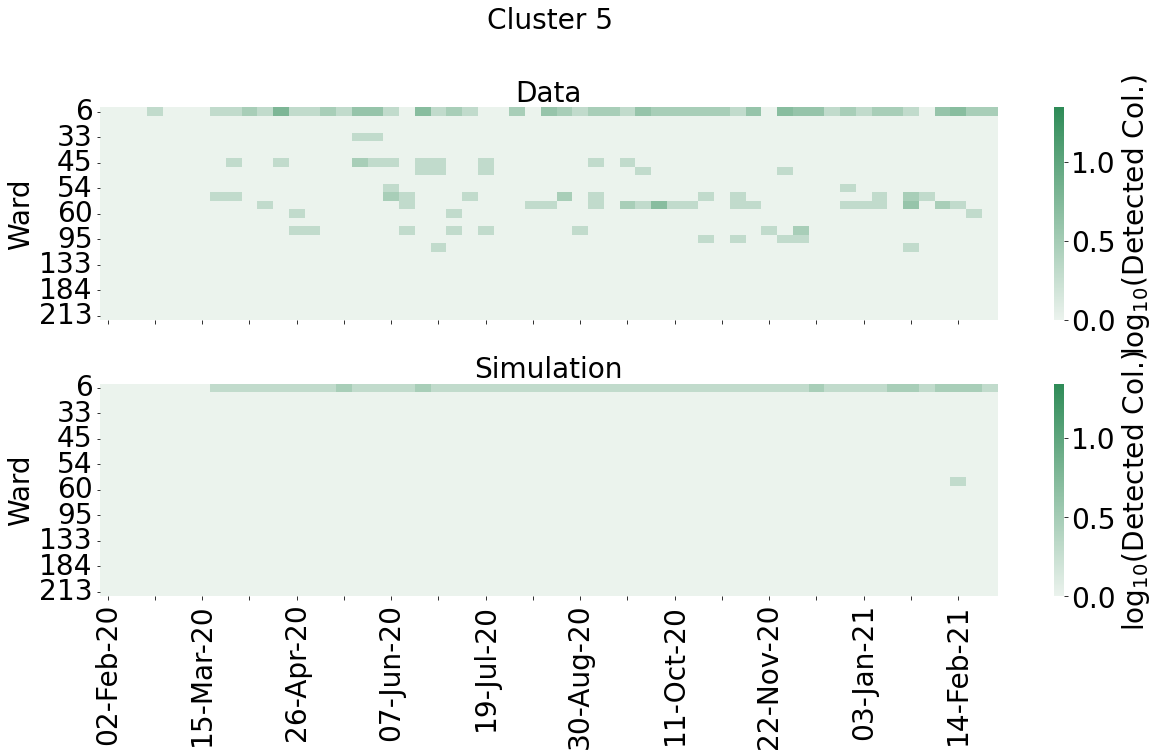

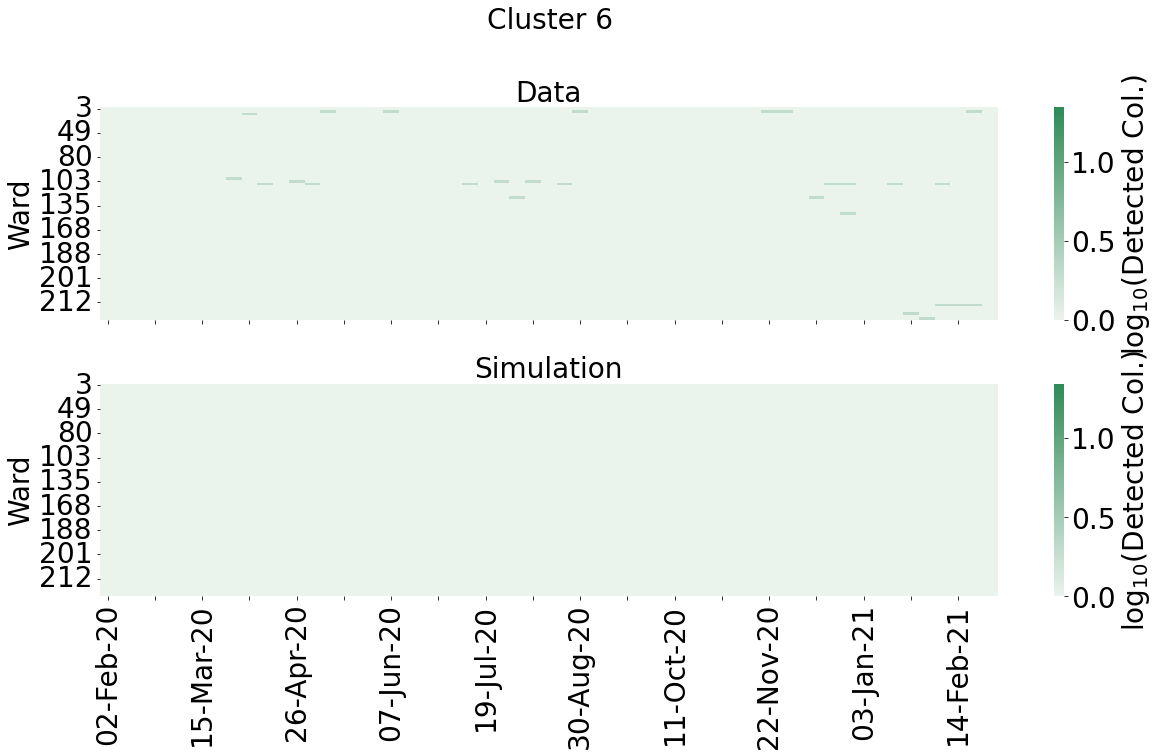

In [36]:
communities   = np.sort(communities_df.community.unique())

ward2community              = communities_df[["ward_id", "community"]].copy()
ward2community["community"][ward2community["community"]>=6] = 6


for comm in [1, 2 , 3 , 4, 5, 6]:
    wards_comm_df = ward2community[ward2community.community==comm]
    wards_commm   = list(wards_comm_df.ward_id)


    data_positive_comm_hm_df = data_positive_hm_df.copy()
    data_positive_comm_hm_df = data_positive_comm_hm_df.reset_index(); data_positive_comm_hm_df = data_positive_comm_hm_df[data_positive_comm_hm_df.ward.isin(wards_commm)].set_index("ward")


    mle_positive_comm_hm_df = mle_positive_hm_df.copy()
    mle_positive_comm_hm_df = mle_positive_comm_hm_df.reset_index(); mle_positive_comm_hm_df = mle_positive_comm_hm_df[mle_positive_comm_hm_df.ward.isin(wards_commm)].set_index("ward")


    fig_dims  = figure_size_setting(1600)
    fig, ax   = plt.subplots(2, 1, figsize=fig_dims, sharex=True, sharey=True)

    g         = sns.heatmap(ax=ax[0], data=np.log10(data_positive_comm_hm_df+1), cmap=sns.light_palette("seagreen", as_cmap=True),  vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})
    g         = sns.heatmap(ax=ax[1], data=np.log10(mle_positive_comm_hm_df+1), cmap=sns.light_palette("seagreen", as_cmap=True), vmin=0, vmax=max_value, cbar_kws={'label': r"$\log_{{10}}$(Detected Col.)"})

    ax[0].set_xlabel(None)
    ax[1].set_xlabel(None)

    ax[0].set_ylabel("Ward")
    ax[1].set_ylabel("Ward")

    ax[0].set_title("Data")
    ax[1].set_title("Simulation")

    #x_tick_labels=['02-Feb','','01-Mar','','29-Mar','','26-Apr','','24-May','','21-Jun','','19-Jul','','16-Aug','','13-Sep','','11-Oct','','08-Nov','','06-Dec','','03-Jan','','31-Jan','','28-Feb']
    x_tick_labels = ['02-Feb-20','','15-Mar-20','', '26-Apr-20', '', '07-Jun-20', '', '19-Jul-20', '', '30-Aug-20', '', '11-Oct-20', '', '22-Nov-20', '', '03-Jan-21', '', '14-Feb-21']

    ax[1].set_xticklabels(x_tick_labels)

    fig.suptitle(f"Cluster {comm}", ha="left", x=0.4)

    plt.tight_layout()

    plt.subplots_adjust(hspace=0.3)

    path_to_save  = os.path.join(path_to_ms_figs, f"HeatmapsWardMean_DataVsSim_Cluster{comm}.png")
    fig.savefig(path_to_save, dpi=300, transparent=True)
